## Project: Computer simulation of a roadblock model of translational control
## Author: Gabin ROUSSEAU

#### Function arguments:

**t = time (number of iterations)**

**a = first site loading probability**

**b = final site unloading probability**

**p = site transition probability**

**L = length of the lattice**

**l = length of a particle passed in the lattice**

**k+ = roadblock binding rate**

**k- = roadblock unbinding rate**

__l* = length of the roadblock__

**B_i = liste of lattice indicies that can be subject to roadblock binding**


**State of an individual site** of index i = **Si** (i=1, ..., L)
With S = {1 if occupied, 0 if empty}

_**Note:** The state of occupation refers to a particle's tracked site exclusively, and the exclusion principle will take that into account to allow passage from one site to another. If all sites blocked by a particle were considered "occupied", it would cause problems when counting the particles on the lattice, especially if the model will end up having to qualify particle types._

**pi = probability of hopping from site i to site i+1** (for i=1,...,L-1) = assumed to be constant here. Should be equal to 1 for phase diagram testing!


Site states will be grouped in the **configuration array C = [S1,..., SL]**

Hopping probabilities will be grouped in the **progression arrary P = [p1,...,pL-1]**


---
_roadblock_ini - v0.5_

## Notes for the implementation of a roadblock (mainly taken from Waclaw et al., 2019)
#### General description
A particle hops from site i to i  +  1 with rate p  if the arrival site i  +  1 is empty. If the arrival site contains a defect, the particle will be blocked. The defect can be thought as representing a physical obstacle blocking the particle. Defects appear and disappear stochastically within the site range indicated: a site without a defect can acquire one with rate k+ , whereas a defect site switches to a non-defect site with rate k.
While the paper suggests a simple model where any site can acquire a defect, defining a specific subset of sites that can be subjected to defect binding is reasonable.

#### New variables
This adds new variables: the defect or roadblocking configuration B (and an associated array of indicies that can receive roadblocks B_i), the defect binding rate k+, the defect unbinding rate k- and the block length l*.
The P array remains in use in case I want to add variations in local hopping rates.

#### Considerations
Should this change only happen as a particle directly approaches the blocked site, or be registered as soon as it is in the l range of sites ahead of the particle? Does it block completely or only reduce the rate?

The model will be constrained (roadblocks cannot bind where a particle is already present) by making the effective k+ "k+*", product of k+ and (1-Si). Likewise, if a roadblock manages to hop despite the reduced rate (if p > 0), does it remove the roadblock or does roadblock unbinding remain independent?

GILLESPIE-SPECIFIC: Do I add the defect dynamics as just one of the decisions that can be made at a given time point? (which affects the exponential distribution by changing the mean) Or should there be a concurrent decision specific to roadblocks?

Should roadblocks only be able to bind unoccupied sites? Needs thinking about how to formulate the conditions.





In [1]:
###############################################################################
#
#       roadblock_ini (rini) v0.5
#                               January 2024
#
#       Author: Gabin Rousseau
#
###############################################################################

#rini dependencies
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random


import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd
import csv

#rini_AvB dependency
import statistics

#to wrap around iterables to display a progress bar
from tqdm import tqdm

In [46]:
#Core function for the model
def rini(t=100, L=30, l=1, a=0.75, b=0.75, p=1, k_on=0.33, k_off=0.33, l_rb=1, B_i=[19]):
    '''
    
    roadblock_ini v0.4 
    (rini for short)
    
    DESCRIPTION:
    This is the 0.4 version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae.
    
    -->Runs an inhomogeneous TASEP model of user-defined parameters that allows for a set particle of variable length, to which the exclusion process self-adapts.
    Returns a dataset containing for each time point:
    1 - The total number of particles that initiated up to that time point "passed_total". (i.e., passed through the lattice. Not to be confused with loading, where a particle enters the lattice. Named so because we model after the ribosome PIC.)
    2 - The state of each lattice site Si (0 or 1). i = 1 ,..., L
    3 - The lattice-wide density d = number of particles / L. Measured at the end of an iteration.
    
    ARGUMENTS: t, L, l, a, b, p
    t:     number of iterations to run the TASEP model; DEFAULT: t=100
    L:     lattice length;                              DEFAULT: L=30
    l:     particle length;                             DEFAULT: l=1
    a:     rate of loading;                             DEFAULT: a=0.75
    b:     rate of unloading;                           DEFAULT: b=0.75
    p:     rate of scanning (i.e., site hopping);       DEFAULT: p=1
    k_on:  rate of blocking;                            DEFAULT: k_on=0.33 
    k_off: rate of unblocking;                          DEFAULT: k_off=0.33
    l_rb:  roadblock length;                            DEFAULT: l_rb=1
    B_i:   blockable lattice index list;                DEFAULT: B_i=[19]
    
    CHANGELOG:
    Changed formulaism to one matching the Gillespie algorithm, for a non-discrete timeline of events that are randomly determined in order and temporal spacing by a,b and p.
    Added to restriction rules: particles can't progress if a particle site is located l places ahead OR a block is located l' ahead (l' being the length of a block).
    With the addition of roadblocks of customisable length
    
    
    '''
    
    #set initial variables
    S_start=0
    C=[] #Lattice configuration
    B=[] #Blocking subconfiguration
    B_i.sort() #sort B_i in ascending order
    P=[] #Site hopping rates
    A=[a] #Gillespie propensities
    for i in range(L):
        C.append(S_start)
        B.append(S_start)
        if i < L-1:
            P.append(p)
        if i > 0: #to not overwrite A0=a
            if i < L-1:
                A.append(C[i]*P[i])
            else:
                A.append(0)
                
    for i in B_i:
        A.append(k_on)
        A.append(0) #k_off position
    
    
   
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    #update with all site configurations
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    #update with all block configurations    
    for i in B_i:
        rini_data.update({f'B{i+1}':[0]})
        
    
    #exclusion rule variables
    S_condition_0=C[0:l]
    B_condition_0=C[0:l_rb]
    
    #time tracker to compare against t
    time = 0
    
    #launch model
    while time <= t:
            #Rolling the random numbers for stochasticity
            R=sum(A)
            if R>0:
                r1=np.random.exponential(1/R)
                r2=np.random.uniform(0,1)*R
                time+=r1
                #determining which site is acted upon
                i = 0 #preparing the index of the moved particle
                r = 0.0 #iterative value that serves to pinpoint the index (rmax=R)
                while r < r2:
                    r += A[i]
                    i += 1
                i-=1

                #LOADING
                if i==0 and C[i]==0:
                    C[0]+=1

                #SCANNING
                elif i<L-1 and C[i]==1:
                    C[i]-=1
                    C[i+1]+=1
                    A[i]=0 #reset propensity for the current move

                #UNLOADING
                elif i==L-1 and C[i]==1:
                    C[i]-=1
                    passed_total+=1
                    A[i]=0 #reset propensity for the current move
                    
                    
                #BLOCKING/UNBLOCKING
                elif i>L-1:
                    i-=L
                    #blocking
                    if (i%2)==0:
                        blocked=B_i[int(i/2)]
                        B[blocked]+=1
                        A[i+L+1]=k_off #instantly flag the site as being unblockable
                    #unblocking
                    else:
                        unblocked=B_i[int((i-1)/2)]
                        B[unblocked]-=1
                        A[i+L]=0
    
                else:
                    print(f'An unexpected error happened at time {time}, please check the code because i={i}, A[i]={A[i]} and R={R}.')

                #UPDATING PROPENSITIES FOR THE NEXT ITERATION: LOADING, PARTICLES AND BLOCKS
                particles=[index for index in range(len(C)) if C[index] == 1]

                #load-ready?
                if C[0]==0:
                    if S_condition_0==C[0:l] and B_condition_0==B[0:l_rb]:
                        A[0]=a
                    else:
                        A[0]=0


                #particle check
                for particle in particles:
                    #unload-ready?
                    if particle==L-1:
                        A[particle]=b
                    #scan-ready?                       
                    
                    else: 
                        particle_token=0 #0 means a particle is ahead
                        roadblock_token=0 #0 means a roadblock is ahead
                        #particle checkpoint
                        if particle <= L-l-1: #can it be blocked by another particle?
                            if C[particle+l]==0: #is it not blocked by a particle?
                                particle_token=1
                        else: #can't be blocked by a particle
                            particle_token=1
                            
                                
                        #roadblock checkpoint
                        if particle <= L-l_rb-1: #can it be blocked by a roadblock?
                            if B[particle+l_rb]==0: #is it not blocked by a roadblock?
                                roadblock_token=1
                        else: #can't be blocked by a roadblock
                            roadblock_token=1
                        
                        #token validation
                        if particle_token==1 and roadblock_token==1:
                            A[particle]=P[particle]
                        else:
                            A[particle]=0
                
                #block-ready?
                for block_ii in range(len(B_i)): #loop through block subindicies (index in the configuration index list)
                    block_i=B_i[block_ii] #get the configuration index
                    #restriction rule for blocking to be possible: depends on particle and block length, assumes the tracking site is at the head of all particles/blocks for rule simplicity.
                    
                    if block_i-l_rb+1 >=0: #if a site is place too close to the entry, this value would be negative, this condition takes this scenario into account
                        if 1 not in C[block_i-l_rb+1:block_i+l] and 1 not in B[block_i-l_rb+1:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                    else:
                        if 1 not in C[0:block_i+l] and 1 not in B[0:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                        

                    
                    
            
                #update dataset
                
                if time <= t:
                    rini_data.setdefault('time', []).append(time)
                elif time > t: #force the final time point to be at time=t if t is exceeded at the end of the run
                    rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
            
            else: #break the loop early to avoid errors in case no action is possible (which should only happen if a rate is null)
                #update dataset
                rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
                break

            #END OF ITERATION
            
            
                
        
    return pd.DataFrame(data=rini_data)

In [2]:
#Core function for the model
def corini(t=100, L=30, l=1, a=0.75, b=0.75, p=1, k_on=0.33, k_off=0.33, l_rb=1, B_i=[19]):
    '''
    
    roadblock_ini v0.4 
    (rini for short)
    
    DESCRIPTION:
    This is the 0.4 version of Gabin ROUSSEAU's model for the roadblock effect of mRNA-binding Ssd1 on translation initiation in S. cerevisiae.
    
    -->Runs an inhomogeneous TASEP model of user-defined parameters that allows for a set particle of variable length, to which the exclusion process self-adapts.
    Returns a dataset containing for each time point:
    1 - The total number of particles that initiated up to that time point "passed_total". (i.e., passed through the lattice. Not to be confused with loading, where a particle enters the lattice. Named so because we model after the ribosome PIC.)
    2 - The state of each lattice site Si (0 or 1). i = 1 ,..., L
    3 - The lattice-wide density d = number of particles / L. Measured at the end of an iteration.
    
    ARGUMENTS: t, L, l, a, b, p
    t:     number of iterations to run the TASEP model; DEFAULT: t=100
    L:     lattice length;                              DEFAULT: L=30
    l:     particle length;                             DEFAULT: l=1
    a:     rate of loading;                             DEFAULT: a=0.75
    b:     rate of unloading;                           DEFAULT: b=0.75
    p:     rate of scanning (i.e., site hopping);       DEFAULT: p=1
    k_on:  rate of blocking;                            DEFAULT: k_on=0.33 
    k_off: rate of unblocking;                          DEFAULT: k_off=0.33
    l_rb:  roadblock length;                            DEFAULT: l_rb=1
    B_i:   blockable lattice index list;                DEFAULT: B_i=[19]
    
    CHANGELOG:
    Changed formulaism to one matching the Gillespie algorithm, for a non-discrete timeline of events that are randomly determined in order and temporal spacing by a,b and p.
    Added to restriction rules: particles can't progress if a particle site is located l places ahead OR a block is located l' ahead (l' being the length of a block).
    With the addition of roadblocks of customisable length
    
    
    '''
    
    #set initial variables
    S_start=0
    C=[] #Lattice configuration
    B=[] #Blocking subconfiguration
    B_i.sort() #sort B_i in ascending order
    P=[] #Site hopping rates
    A=[a] #Gillespie propensities
    for i in range(L):
        C.append(S_start)
        B.append(S_start)
        if i < L-1:
            P.append(p)
        if i > 0: #to not overwrite A0=a
            if i < L-1:
                A.append(C[i]*P[i])
            else:
                A.append(0)
                
    for i in B_i:
        A.append(k_on)
        A.append(0) #k_off position
    
    
   
    passed_total=0 #counter for particles that terminated scanning
    
    #prepare returned dataset
    rini_data={'time':[0], 'passed_total':[0], 'density':[0]}
    loc1=0
    #update with all site configurations
    for S in C:
        loc1+=1
        rini_data.update({f'S{loc1}':[0]})
    #update with all block configurations    
    for i in B_i:
        rini_data.update({f'B{i+1}':[0]})
        
    
    #exclusion rule variables
    S_condition_0=C[0:l]
    B_condition_0=C[0:l_rb]
    
    #time tracker to compare against t
    time = 0
    
    #launch model
    while time <= t:
            #Rolling the random numbers for stochasticity
            R=sum(A)
            if R>0:
                r1=np.random.exponential(1/R)
                r2=np.random.uniform(0,1)*R
                time+=r1
                #determining which site is acted upon
                i = 0 #preparing the index of the moved particle
                r = 0.0 #iterative value that serves to pinpoint the index (rmax=R)
                while r < r2:
                    r += A[i]
                    i += 1
                i-=1

                #LOADING
                if i==0 and C[i]==0:
                    C[0]+=1

                #SCANNING
                elif i<L-1 and C[i]==1:
                    C[i]-=1
                    C[i+1]+=1
                    A[i]=0 #reset propensity for the current move

                #UNLOADING
                elif i==L-1:
                    C[i]-=1
                    passed_total+=1
                    A[i]=0 #reset propensity for the current move
                    
                    
                #BLOCKING/UNBLOCKING
                elif i>L-1:
                    i-=L
                    #blocking
                    if (i%2)==0:
                        blocked=B_i[int(i/2)]
                        B[blocked]+=1
                        A[i+L+1]=k_off #instantly flag the site as being unblockable
                    #unblocking
                    else:
                        unblocked=B_i[int((i-1)/2)]
                        B[unblocked]-=1
                        A[i+L]=0
    
                else:
                    print(f'An unexpected error happened at time {time}, please check the code because i={i} and R={R}.')

                #UPDATING PROPENSITIES FOR THE NEXT ITERATION: LOADING, PARTICLES AND BLOCKS
                particles=[index for index in range(len(C)) if C[index] == 1]

                #load-ready?
                if C[0]==0:
                    if S_condition_0==C[0:l] and B_condition_0==B[0:l_rb]:
                        A[0]=a
                    else:
                        A[0]=0


                #particle check
                for particle in particles:
                    #unload-ready?
                    if particle==L-1:
                        A[particle]=b
                    #scan-ready?                       
                    else:  
                        if particle <= L-l_rb-1: #can it be blocked by a roadblock?
                            if B[particle+l_rb]==0: #is it not blocked by a rb?
                                if particle <= L-l-1: #can it be blocked by another particle?
                                    if C[particle+l]==0: #is it not blocked by a p?
                                        A[particle]=P[particle]
                                        
                                    else:
                                        A[particle]=0
                                else:
                                    A[particle]=P[particle]
                            else:
                                A[particle]=0
                        else:
                            A[particle]=P[particle]
                
                #block-ready?
                for block_ii in range(len(B_i)): #loop through block subindicies (index in the configuration index list)
                    block_i=B_i[block_ii] #get the configuration index
                    #restriction rule for blocking to be possible: depends on particle and block length, assumes the tracking site is at the head of all particles/blocks for rule simplicity.
                    
                    if block_i-l_rb+1 >=0: #if a site is place too close to the entry, this value would be negative, this condition takes this scenario into account
                        if 1 not in C[block_i-l_rb+1:block_i+l] and 1 not in B[block_i-l_rb+1:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                    else:
                        if 1 not in C[0:block_i+l] and 1 not in B[0:block_i+l_rb]:
                            A[L+(block_ii*2)]=k_on
                        else:
                            A[L+(block_ii*2)]=0
                        

                    
                    
            
                #update dataset
                
                if time <= t:
                    rini_data.setdefault('time', []).append(time)
                elif time > t: #force the final time point to be at time=t if t is exceeded at the end of the run
                    rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
            
            else: #break the loop early to avoid errors in case no action is possible (which should only happen if a rate is null)
                #update dataset
                rini_data.setdefault('time', []).append(t)

                rini_data.setdefault('passed_total', []).append(passed_total)

                particle_count=0

                loc3=0
                for S in C:
                    loc3+=1
                    rini_data.setdefault(f'S{loc3}', []).append(S)
                    if S==1:
                        particle_count+=1

                d=round(particle_count/L,2) #lattice density rounded to 2 decimals
                rini_data.setdefault('density', []).append(d)
                
                for i in B_i:
                    rini_data.setdefault(f'B{i+1}', []).append(B[i])
                break

            #END OF ITERATION
            
            
                
        
    return pd.DataFrame(data=rini_data)

In [4]:
#create a function that returns an initiation rate estimate
#for starters, calculate regression from time point t=L (to eliminate the expected phase of scanning for an uninterrupted first particle where the first initiation has yet to occur)
#note to self: exit flow: total exit count divided by time, might be even more relevant with Gillespie
def rini_I(t=100, L=30, l=1, a=0.75, b=0.75, p=1):
    '''
    rini_I for rini v0.4
    Estimates the initiation rate of the rini model as the simple exit current J=max(passed_total)/t.
    '''
    #Define the rini model run with the input parameters
    rini_data=rini(t,L,l,a,b,p) 
    
    I=max(rini_data['passed_total'])/t
    
        
    return round(I,2)

In [5]:
#Plots changes in exit rate over alpha and beta
def rini_IvAB(t=100, L=30, l=1, a=1, b=1, p=1, a_range=np.arange(0,1,0.02), b_range=np.arange(0,1,0.02), out=False):
    '''
    For rini v0.4
    Measures I against a range of alpha values and beta values respectively. In either case, a default value for the other parameter is set (default:0.75).
    Plots the comparison in two separate figures.
    The user can specify the range of values considered in addition to the base rini parameters in the form of numpy.arange() arrays.
    Optionally returns the dataset used for plotting.
    '''
    #open data dictionary
    IvAB={'alpha':[],'I_a':[], 'beta':[],'I_b':[]}
    
    #Tie initiation rates to variable alpha or beta values
    for alpha in a_range:
        IvAB.setdefault('alpha', []).append(alpha)
        IvAB.setdefault('I_a', []).append(rini_I(t, L, l, alpha, b, p))
    for beta in b_range:
        IvAB.setdefault('beta', []).append(beta)
        IvAB.setdefault('I_b', []).append(rini_I(t, L, l, a, beta, p))
    #convert to pandas dataframe
    IvAB_data= pd.DataFrame(data=IvAB)
    
    #plot
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    sns.lineplot(x='alpha', y='I_a', data=IvAB_data)
    plt.xlabel('Alpha')
    plt.ylabel('Initiation rate')
    
    plt.subplot(122)
    sns.lineplot(x='beta', y='I_b', data=IvAB_data)
    plt.xlabel('Beta')
    plt.ylabel('Initiation rate')
    
    plt.tight_layout()
    plt.show();
    
    if out==True:
        print('Dataset returned.')
        return IvAB_data
        

In [7]:
#Plots the phase diagram
def rini_AvB(t=500, L=100, l=1, p=1, tags=False, randomised=False, n=10, B_i=[19]):
    '''
    For rini v0.4
    Plots alpha against beta. By default, plots 3 points expected to fit the respective density phases of TASEP and prints the median lattice occupation density over each point.
    If the 'randomised' argument is set to True, a selectable amount of points (n) will be made for random combinations of a and b.
    '''
    #open data dictionary
    AvB={'alpha':[], 'beta':[], 'mean_d':[], 'd_phase':[], 'expect_d':[]}
    
    if randomised==False:
        #prepare 3 points for LD, HD, and MC scenarios in order
        combi=[[0.25,0.75],[0.75,0.25],[0.75,0.75]]
        for a, b in combi:
            mean_density=statistics.mean(rini(t, L, l, a, b, p, B_i=B_i)['density'])
            AvB.setdefault('alpha', []).append(a)
            AvB.setdefault('beta', []).append(b)
            AvB.setdefault('mean_d', []).append(mean_density)
            #LOW DENSITY EXPECTED
            if a<0.5 and a<b:
                AvB.setdefault('d_phase', []).append('LD')
                AvB.setdefault('expect_d', []).append(a)
                
            #HIGH DENSITY EXPECTED
            elif b<0.5 and b<a:
                AvB.setdefault('d_phase', []).append('HD')
                AvB.setdefault('expect_d', []).append(1-b)
            #MAXIMUM CURRENT EXPECTED
            elif a>0.5 and b>0.5:
                AvB.setdefault('d_phase', []).append('MC')
                AvB.setdefault('expect_d', []).append(0.5)
            
            else:
                AvB.setdefault('d_phase', []).append('NA')
                AvB.setdefault('expect_d', []).append(0)
                
                
            
                        
    elif randomised==True:
        for i in range(n):
            a=round(random.uniform(0.1,1),2)
            b=round(random.uniform(0.1,1),2)
            mean_density=statistics.mean(rini(t, L, l, a, b, p, B_i=B_i)['density'])
            AvB.setdefault('alpha', []).append(a)
            AvB.setdefault('beta', []).append(b)
            AvB.setdefault('mean_d', []).append(mean_density)
            #LOW DENSITY EXPECTED
            if a<0.5 and a<b:
                AvB.setdefault('d_phase', []).append('LD')
                AvB.setdefault('expect_d', []).append(a)
                
            #HIGH DENSITY EXPECTED
            elif b<0.5 and b<a:
                AvB.setdefault('d_phase', []).append('HD')
                AvB.setdefault('expect_d', []).append(1-b)
            #MAXIMUM CURRENT EXPECTED
            elif a>0.5 and b>0.5:
                AvB.setdefault('d_phase', []).append('MC')
                AvB.setdefault('expect_d', []).append(0.5)
            
            else:
                AvB.setdefault('d_phase', []).append('NA')
                AvB.setdefault('expect_d', []).append(0)
            
        
        
    
    #convert to pandas dF
    AvB_data= pd.DataFrame(data=AvB)
    #plot AvB
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    sns.scatterplot(x='alpha', y='beta', hue='d_phase', data=AvB_data)
    #frame the phases
    plt.plot([0,0.5], [0,0.5], color='r')
    plt.plot([0.5,0.5], [0.5,1.0], color='r')
    plt.plot([0.5,1.0], [0.5,0.5], color='r')
    
    #assign labels to points
    if tags==True:
        for point in range(len(AvB_data['mean_d'])):
            x=AvB_data['alpha'][point]
            y=AvB_data['beta'][point]
            plt.text(x+0.01,y+0.01,f'{point}',size=10)
    plt.xticks(np.arange(0, 1.1, step=0.5))
    plt.yticks(np.arange(0, 1.1, step=0.5))
    plt.xlabel('Alpha')
    plt.ylabel('Beta')
    plt.legend(title='Density Phase', labelcolor='mfc',bbox_to_anchor=(1,1))
    
    #plot median vs. expected
    plt.subplot(122)
    plt.plot([0.0,1.0], [0.0,1.0], '--', color='r')
    sns.scatterplot(x='expect_d', y='mean_d', hue='d_phase', data=AvB_data)
    if tags==True:
        for point in range(len(AvB_data['mean_d'])):
            x=AvB_data['expect_d'][point]
            y=AvB_data['mean_d'][point]
            plt.text(x+0.01,y+0.01,f'{point}',size=10)
    plt.xticks(np.arange(0, 1, step=0.1))
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.xlabel('Expected bulk density')
    plt.ylabel('Average occupation density')
    plt.legend(title='Density Phase', labelcolor='mfc',bbox_to_anchor=(1,1))
    
    
    plt.tight_layout()
    plt.show();
    
    
    
    
    

In [51]:
#Plots the average occupancy for every site at a given time 
def rinimo(t=10000, L=30, l=1, a=0.75, b=0.75, p=1, k_on=0.33, k_off=0.33, l_rb=1, B_i=[19], timepoint=5000, n=100, dataset=False, visual=True):
    '''
    For rini v0.4
    
    rinimo or "rini_mean_occupancy"
    
    Takes in the usual rini parameters and "timepoint", that defines for which time point of the run average occupancies should be computed; 
    "n" defines how many rini runs will be sampled for the plot.
    "dataset" is a boolean that enables the function to the return the mean_occupancy dataset. (default: False)
    "visual" is a boolean that enables the function to plot the mean occupancies over their lattice sites. (default: True)
    '''
    #open data lists
    site=[] #columns for site numbers
    occupancy=[] #column for corresponding occupancies tallied n samples at time=timepoint
    for i in range(L):
        site.append(i+1)
        occupancy.append(0)
        
    
    
    #Launch n runs and tally occupancies
    for i in tqdm(range(n)):
        run=rini(t,L,l,a,b,p,k_on,k_off,l_rb,B_i)
        cropped_run=run.loc[run['time']<=timepoint]
        timed_run=cropped_run.iloc[(cropped_run['time']-timepoint).abs().argsort()[:1]]
        
        for ii in range(L):
            occupancy[ii]+=float(timed_run[f'S{ii+1}'].iloc[0])
    mean_occupancy=[occupied/n for occupied in occupancy]
    
    rinimo_data=pd.DataFrame(list(zip(site, mean_occupancy)), columns =['site', 'mean_occupancy'])
    
    if dataset==True:
        return rinimo_data
        print("Dataset returned.")
    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(121)
        sns.lineplot(x='site', y='mean_occupancy', color='orange', data=rinimo_data)
        if B_i!=[]:
            for i in B_i:
                plt.plot([i+1,i+1], [0,1],'--', color='r')
                
        
        plt.xticks(np.arange(0, L+2, step=2))
        plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xlabel('Site number')
        plt.ylabel(f'Average occupancy at t={timepoint}')

        plt.tight_layout()
        plt.show();
    
        
    
    
    
        
    


In [4]:
#Plots a standardised initiation (protein production proxy) value against the number of blockable sites used
def rini_INIvBLOCK(t=10000, L=30, l=1, a=0.75, b=0.75, p=1, k_on=0.33, k_off=0.33, l_rb=1, B_i=[19, 24], timepoint=10000, n=10, dataset=False, visual=True):
    '''
    For rini v0.4
    
    rini_INIvBLOCK: function to plot a standardised measure of the exit count (represents initiation/protein production) against the number of blocks.
    
    Takes in the usual rini parameters and "timepoint", that defines for which time point of the run average occupancies should be computed; 
    "n" defines how many rini runs will be sampled for the plot.
    "dataset" is a boolean that enables the function to the return the mean_occupancy dataset. (default: False)
    "visual" is a boolean that enables the function to plot the mean occupancies over their lattice sites. (default: True)
    '''
    #open data lists
    repetition=[] #column for repetition IDs
    blocks=[] #columns for blockable site counts
    exits=[] #column for standardised mean exits
      
    blockcount=len(B_i)+1
    
    
    #Launch n runs and calculate standardised mean exits
    exits_zero=0 #tally exits for zero blocks to establish a mean standard
    #loop for as many repetitions as required
    for i in tqdm(range(n)):
        #record total particle exits for each block scenario
        for ii in range(blockcount):
            
            current_run=rini(t,L,l,a,b,p,k_on,k_off,l_rb,B_i[0:ii])
            cropped_run=current_run.loc[current_run['time']<=timepoint]
            timed_run=cropped_run.iloc[(cropped_run['time']-timepoint).abs().argsort()[:1]]
            
           
            repetition.append(i)
            blocks.append(ii)
            current_exits=float(timed_run['passed_total'].iloc[0])
            exits.append(current_exits)
            if ii == 0:
                exits_zero+=current_exits
    mean_exits_zero=exits_zero/n        
    standardised_exits=[x/mean_exits_zero for x in exits]   
    
    rini_INIvBLOCK_data=pd.DataFrame(list(zip(repetition, blocks, standardised_exits)), columns = ['repetition_number', 'block_number','initiation'])
    
    if dataset==True:
        return rini_INIvBLOCK_data
        print("Dataset returned.")
    
    if visual==True:
        plt.figure(figsize = (12, 4))
        plt.subplot(121)
        sns.pointplot(x='block_number', y='initiation', errorbar="sd", data=rini_INIvBLOCK_data)
                
        
        #plt.xticks(np.arange(0, L+2, step=2))
        #plt.yticks(np.arange(0, 1.1, step=0.1))
        plt.xlabel('Number of blockable sites')
        plt.ylabel('Initiation efficiency')
        plt.title(f'Initiation efficiency vs. number of blocks | Sites:{[x+1 for x in B_i]} | Pb = {round(k_on/(k_on+k_off)*100,1)}% | n = {n}')

        plt.tight_layout()
        plt.show();

In [10]:
#testing rini sampling at the closest timepoint below a chosen value
run=rini(t=10000)
cropped_run=run.loc[run['time']<=5000]
timed_run=cropped_run.iloc[(cropped_run['time']-5000).abs().argsort()[:1]]
float(timed_run['S2'].iloc[0])

0.0

In [6]:
#Check the output of rini
model_test=rini(t=10000,l=3,l_rb=2,B_i=[1,8,9,19,25])
model_test
#model_test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-4_output/table2.csv')

time  passed_total  density  S1  S2  S3  S4  S5  S6  S7  ...  \
0          0.000000             0     0.00   0   0   0   0   0   0   0  ...   
1          0.106918             0     0.00   0   0   0   0   0   0   0  ...   
2          0.667423             0     0.00   0   0   0   0   0   0   0  ...   
3          2.024165             0     0.00   0   0   0   0   0   0   0  ...   
4          3.176290             0     0.00   0   0   0   0   0   0   0  ...   
...             ...           ...      ...  ..  ..  ..  ..  ..  ..  ..  ...   
38634   9999.445609          1081     0.20   0   0   0   0   1   0   0  ...   
38635   9999.733433          1081     0.20   0   0   0   0   1   0   0  ...   
38636   9999.805461          1081     0.20   0   0   0   0   1   0   0  ...   
38637   9999.808107          1081     0.23   1   0   0   0   1   0   0  ...   
38638  10000.000000          1081     0.23   1   0   0   0   1   0   0  ...   

       S26  S27  S28  S29  S30  B2  B9  B10  B20  B26  
0        0    0    0    0    0   0   0    0    0    0  
1        0    0    0    0    0   0   1    0    0    0  
2        0    0    0    0    0   1   1    0    0    0  
3        0    0    0    0    0   1   1    0    1    0  
4        0    0    0    0    0   0   1    0    1    0  
...    ...  ...  ...  ...  ...  ..  ..  ...  ...  ...  
38634    0    0    0    0    0   0   0    0    0    0  
38635    0    0    0    0    0   0   0    0    0    0  
38636    1    0    0    0    0   0   0    0    0    0  
38637    1    0    0    0    0   0   0    0    0    0  
38638    1    0    0    0    0   0   0    0    0    0  

[38639 rows x 38 columns]

In [47]:
#Visualise the exits over time + linear regression used to determine the rate
rini_I(t=10000)

0.22

In [265]:
#Visualise the exits + regression when a rate is severely limiting the progress of the model
rini_I(t=10000, L=30, l=1, a=0.01, b=1, p=1)

0.01

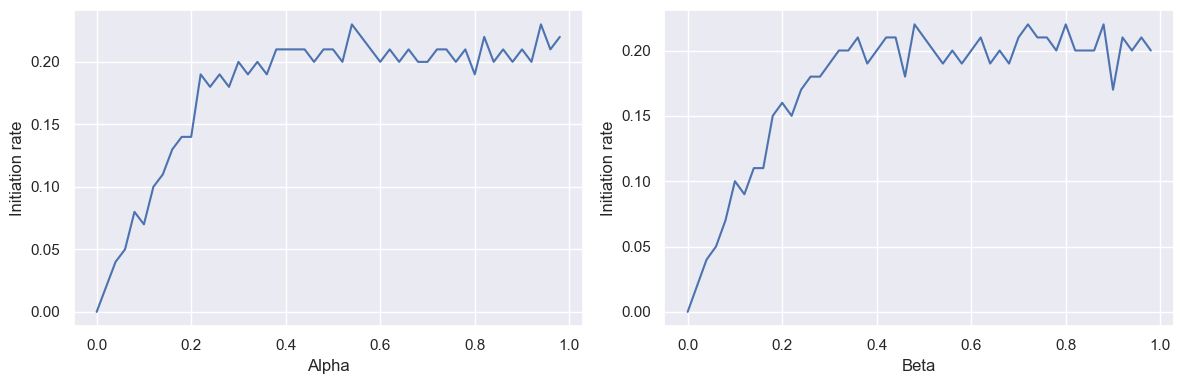

In [48]:
#Visualise changes in the initiation rate depending on either alpha or beta
#On the left, b=1; on the right, a=1
rini_IvAB(1000)

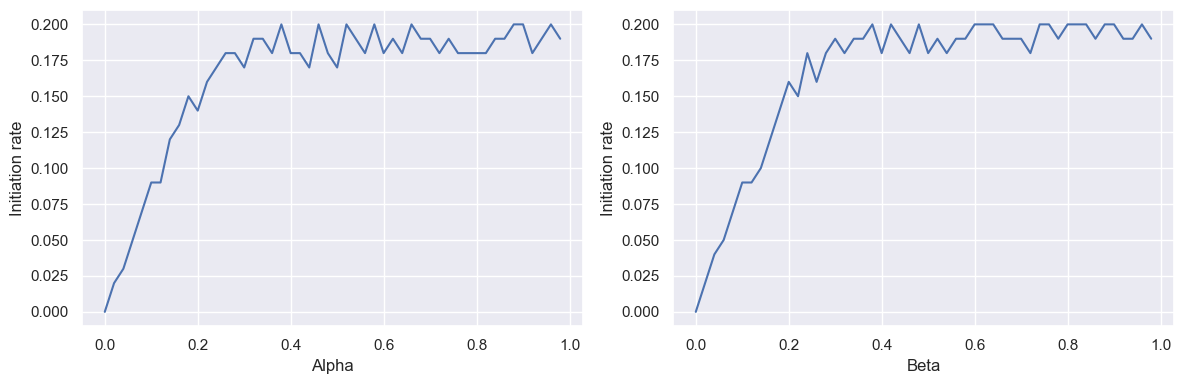

In [49]:
#Same as above but the constant rates are 0.3 instead of 1.
rini_IvAB(a=0.3,b=0.3,t=1000)

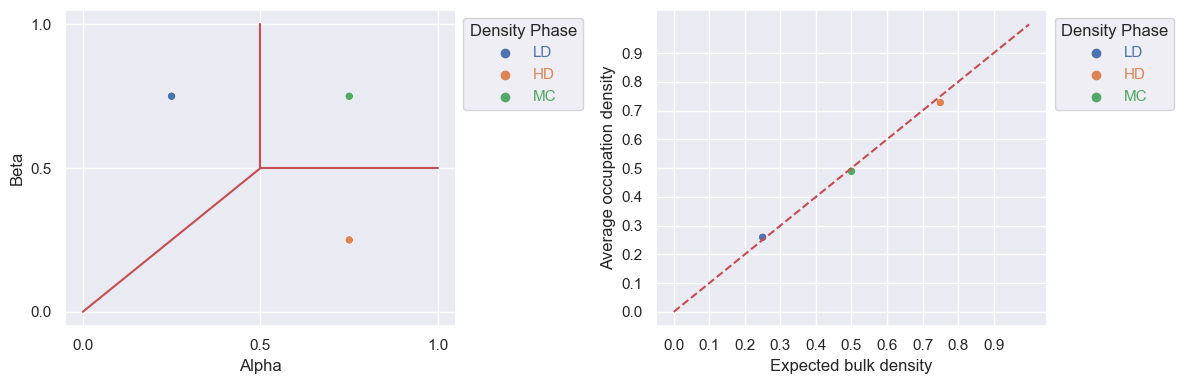

In [5]:
#Plot a phase diagram with a representative point for each phase
rini_AvB(t=10000,B_i=[])

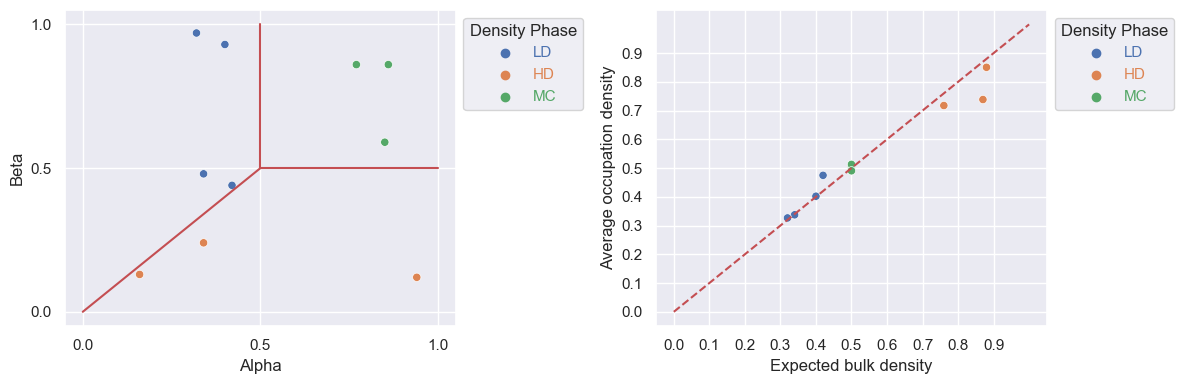

In [6]:
#Phase diagram with 10 random points
rini_AvB(randomised=True, n=10,t=10000, B_i=[])

In [7]:
#affix a run of rini to a variable and save the table if needed
model_test=rini(t=10000)
#model_test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-4_output/table.csv')

In [8]:
#count the time percentage during which the blocked site was occupied in model_test, express the probability of blocking Pb
B_count=len(model_test['B20'].loc[model_test['B20']==1])
run_len=len(model_test['B20'])
Pb=0.5

print(f'Site 20 was blocked {B_count/run_len*100}% of the time. Pb = {Pb}')

Site 20 was blocked 27.659544037300837% of the time. Pb = 0.5


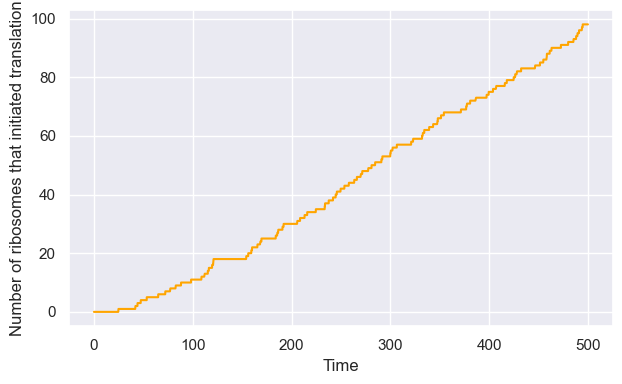

In [54]:
#INITIATED VS. TIME model_test
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='passed_total', data=model_test, color='orange')

plt.xlabel('Time')
plt.ylabel('Number of ribosomes that initiated translation')

plt.tight_layout()
plt.show();

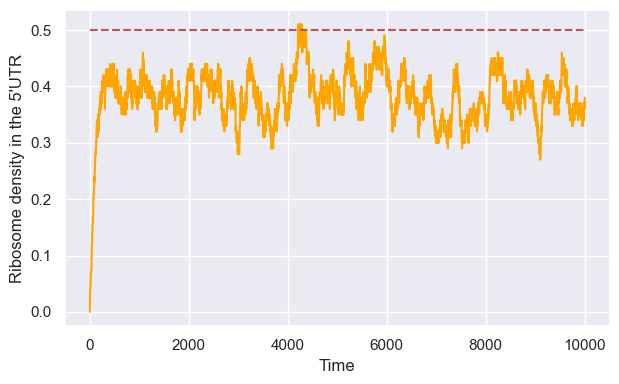

In [55]:
#DENSITY VS. TIME Max current (a and b >1/2)
#EXPECTED: d=1/2
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(t=10000, L=100), color='orange')
plt.plot([0,10000], [0.5,0.5], '--',color='r')

plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

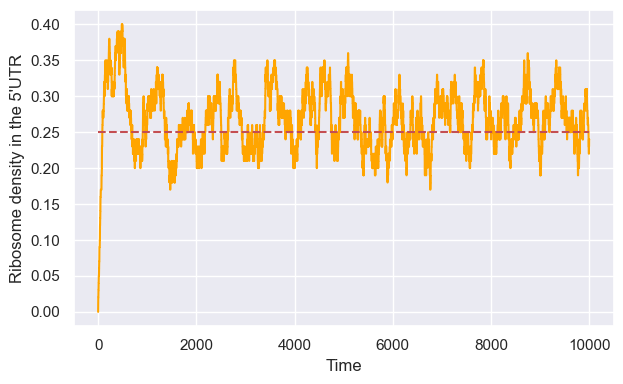

In [56]:
#DENSITY VS. TIME Low density (a < 1/2 and a < b)
#EXPECTED: d=a (0.25 here)
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(a=0.25, t=10000, L=100), color='orange')
plt.plot([0,10000], [0.25,0.25], '--',color='r')
plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

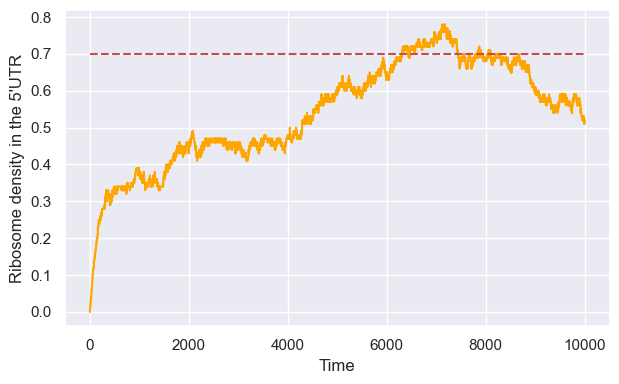

In [9]:
#DENSITY VS. TIME High density (b < 1/2 and a > b)
#EXPECTED: d=1-b (b=0.3 here so 0.7)
plt.figure(figsize = (12, 4))
plt.subplot(121)
sns.lineplot(x='time', y='density', data=rini(b=0.3,t=10000,L=200), color='orange')
plt.plot([0,10000], [0.7,0.7], '--',color='r')
plt.xlabel('Time')
plt.ylabel("Ribosome density in the 5'UTR")

plt.tight_layout()
plt.show();

100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


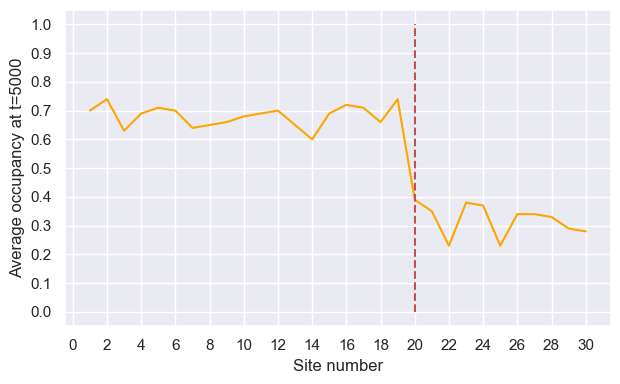

In [39]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=5000, runtime 10000, n=100 samples, L=30, block at site 20, Pb=0.5
rinimo()

100%|██████████| 100/100 [03:41<00:00,  2.22s/it]


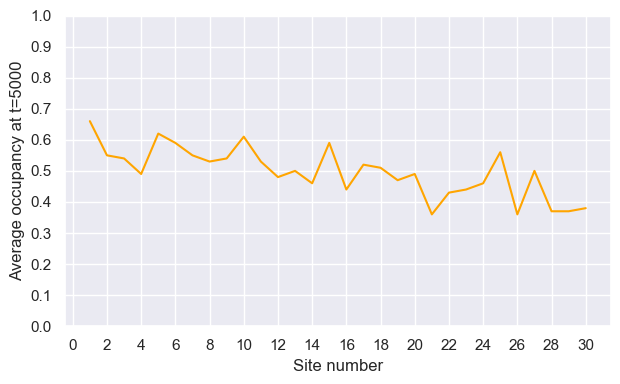

In [35]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=5000, runtime 10000, n=100 samples, L=30, no blockable site
rinimo(B_i=[])

100%|██████████| 1000/1000 [33:56<00:00,  2.04s/it]


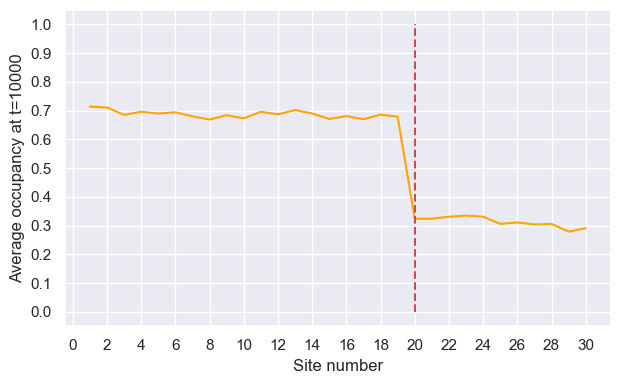

In [40]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=10000, n=1000 samples, L=30, block at site 20, Pb=0.5 (0.33/0.33)
rinimo(timepoint=10000,n=1000)

100%|██████████| 1000/1000 [37:04<00:00,  2.22s/it]


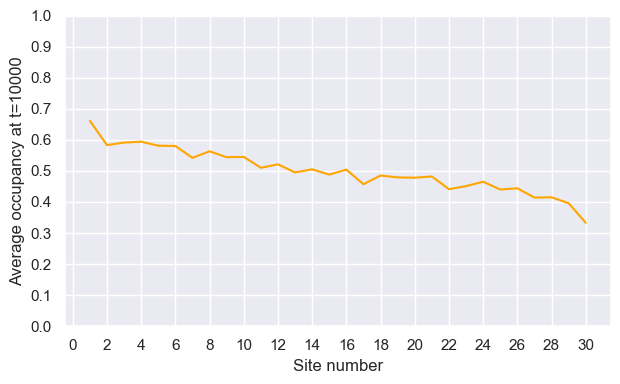

In [41]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=10000, n=1000 samples, L=30, no blockable site
rinimo(timepoint=10000,n=1000,B_i=[])

100%|██████████| 200/200 [10:23<00:00,  3.12s/it]


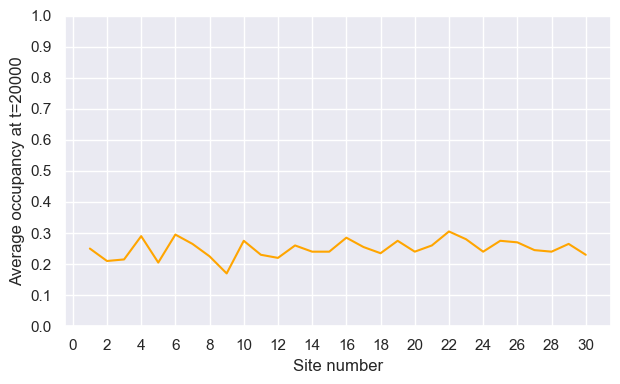

In [10]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=20000, n=200 samples, L=30, no blockable site, a= 1-b
rinimo(t=20000,L=30,a=0.25,b=0.75,timepoint=20000,n=200,B_i=[])


In [11]:
#PLOT THE AVERAGE OCCUPANCY PROFILE AT T=20000, n=200 samples, L=200, no blockable site, a and b =0.75
rinimo(t=20000,L=200,a=0.75,b=0.75,timepoint=20000,n=200,B_i=[])


  0%|          | 1/200 [03:55<12:59:43, 235.09s/it]


KeyboardInterrupt: 

In [30]:
#SAVE THE RINIMO DATASET T=5000, runtime 10000, n=100 samples, L=30
test=rinimo(dataset=True, visual=False)
#test.to_csv(path_or_buf='/home/gabin_r/Documents/ROADBLOCK_ub/rini_v0-4_output/rinimo_table.csv')

100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


100%|██████████| 10/10 [04:59<00:00, 29.91s/it]


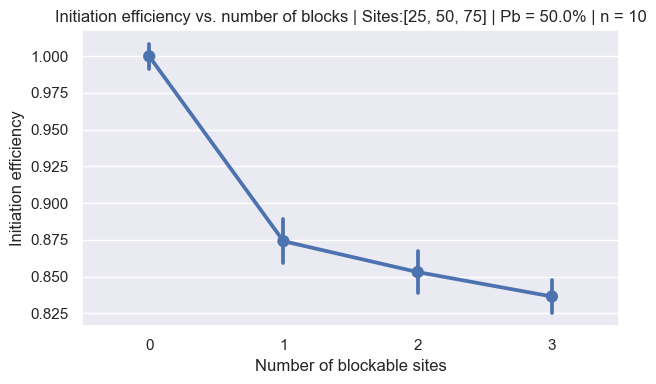

In [14]:
# 1 - PLOT A DEFAULT INITIATION VS. BLOCKS PROFILE (3 blocks)
rini_INIvBLOCK(t=5000, L=100, l=1, a=0.6, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[24, 49, 74], timepoint=5000, n=10)

100%|██████████| 10/10 [03:47<00:00, 22.75s/it]


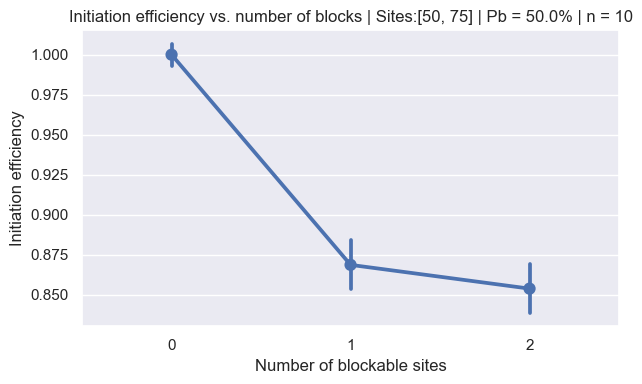

In [15]:
# 2 - PLOT AN INITIATION VS. BLOCKS PROFILE (default without the first block)
rini_INIvBLOCK(t=5000, L=100, l=1, a=0.6, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[49, 74], timepoint=5000, n=10)

100%|██████████| 10/10 [07:35<00:00, 45.53s/it]


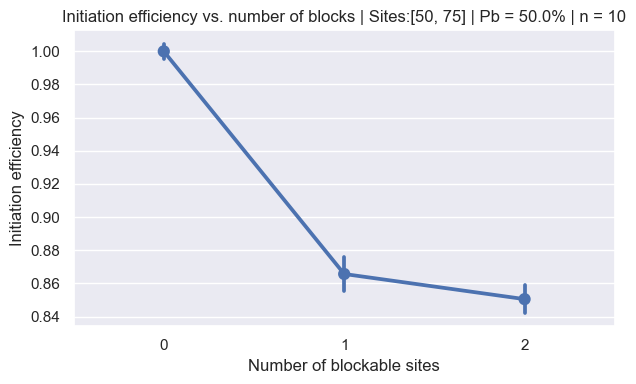

In [16]:
# 3 - PLOT AN INITIATION VS. BLOCKS PROFILE (double time)
rini_INIvBLOCK(t=10000, L=100, l=1, a=0.6, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[49, 74], timepoint=10000, n=10)



100%|██████████| 10/10 [01:10<00:00,  7.02s/it]


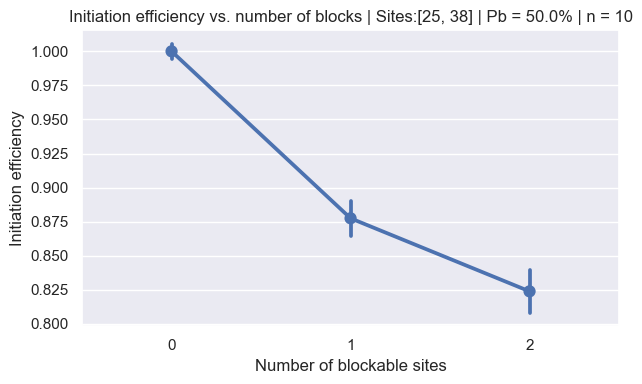

In [18]:
# 4 - PLOT AN INITIATION VS. BLOCKS PROFILE (half L)
rini_INIvBLOCK(t=5000, L=50, l=1, a=0.6, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[24, 37], timepoint=5000, n=10)


100%|██████████| 10/10 [13:18<00:00, 79.88s/it]


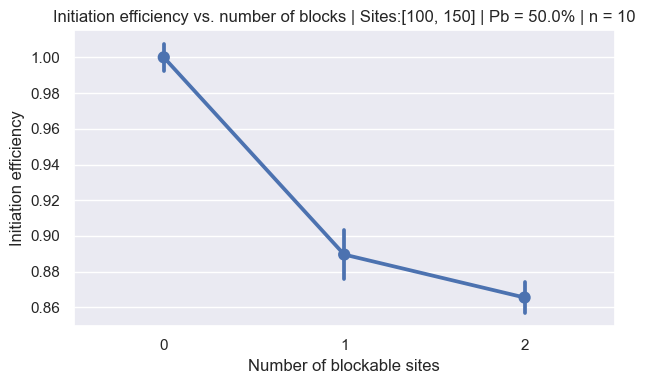

In [19]:
# 5 - PLOT AN INITIATION VS. BLOCKS PROFILE (double L)
rini_INIvBLOCK(t=5000, L=200, l=1, a=0.6, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[99, 149], timepoint=5000, n=10)

100%|██████████| 10/10 [02:02<00:00, 12.27s/it]


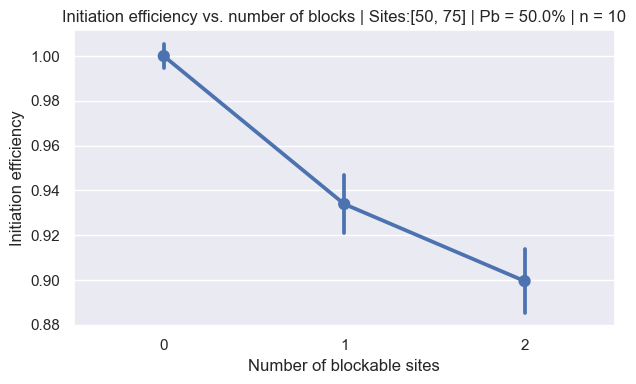

In [20]:
# 4 - PLOT AN INITIATION VS. BLOCKS PROFILE (l=3)
rini_INIvBLOCK(t=5000, L=100, l=3, a=0.6, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[49, 74], timepoint=5000, n=10)

In [21]:
# 4 - PLOT AN INITIATION VS. BLOCKS PROFILE (l_rb=3)
rini_INIvBLOCK(t=5000, L=100, l=1, a=0.6, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=3, B_i=[49, 74], timepoint=5000, n=10)

  0%|          | 0/10 [00:00<?, ?it/s]

An unexpected error happened at time 143.5533758159535, please check the code because i=98 and R=20.6.
An unexpected error happened at time 144.00320953542538, please check the code because i=98 and R=23.6.
An unexpected error happened at time 145.30511487094546, please check the code because i=98 and R=20.6.
An unexpected error happened at time 145.63019498626068, please check the code because i=98 and R=22.6.
An unexpected error happened at time 150.55458963015175, please check the code because i=98 and R=21.6.
An unexpected error happened at time 151.3993105378885, please check the code because i=98 and R=21.6.
An unexpected error happened at time 152.3130412859177, please check the code because i=98 and R=21.6.
An unexpected error happened at time 154.2860576977622, please check the code because i=98 and R=22.
An unexpected error happened at time 155.2627047833241, please check the code because i=98 and R=22.
An unexpected error happened at time 155.51189625046234, please check the

An unexpected error happened at time 340.4058320848271, please check the code because i=98 and R=30.6.
An unexpected error happened at time 342.80419625148846, please check the code because i=98 and R=28.6.
An unexpected error happened at time 343.0473380750003, please check the code because i=98 and R=29.6.
An unexpected error happened at time 343.11937272936154, please check the code because i=98 and R=28.6.
An unexpected error happened at time 343.37629721261925, please check the code because i=98 and R=28.6.
An unexpected error happened at time 344.8074678283478, please check the code because i=98 and R=26.
An unexpected error happened at time 345.72571720954085, please check the code because i=98 and R=25.
An unexpected error happened at time 347.65196941952956, please check the code because i=98 and R=24.
An unexpected error happened at time 347.8800778005044, please check the code because i=98 and R=22.
An unexpected error happened at time 347.9900251469261, please check the cod

An unexpected error happened at time 514.8383167018832, please check the code because i=98 and R=27.6.
An unexpected error happened at time 516.1153046927537, please check the code because i=98 and R=29.
An unexpected error happened at time 516.2762603405836, please check the code because i=98 and R=29.
An unexpected error happened at time 517.4866037450433, please check the code because i=98 and R=26.
An unexpected error happened at time 518.3012308590163, please check the code because i=98 and R=24.6.
An unexpected error happened at time 519.7771110780586, please check the code because i=98 and R=24.
An unexpected error happened at time 521.1650908390762, please check the code because i=98 and R=24.
An unexpected error happened at time 521.5024234002366, please check the code because i=98 and R=25.
An unexpected error happened at time 522.2660929479649, please check the code because i=98 and R=23.
An unexpected error happened at time 523.2455951009841, please check the code because i

An unexpected error happened at time 701.6347275953929, please check the code because i=98 and R=29.
An unexpected error happened at time 702.2233410465577, please check the code because i=98 and R=27.6.
An unexpected error happened at time 702.5275605095144, please check the code because i=98 and R=28.6.
An unexpected error happened at time 704.0442110558894, please check the code because i=98 and R=27.6.
An unexpected error happened at time 704.1998726802573, please check the code because i=98 and R=28.6.
An unexpected error happened at time 704.4190708275466, please check the code because i=98 and R=26.6.
An unexpected error happened at time 705.0192359016662, please check the code because i=98 and R=25.6.
An unexpected error happened at time 705.9927334942274, please check the code because i=98 and R=25.6.
An unexpected error happened at time 707.8490523812459, please check the code because i=98 and R=27.
An unexpected error happened at time 708.8854251851426, please check the code

An unexpected error happened at time 884.1293500251857, please check the code because i=98 and R=24.
An unexpected error happened at time 885.6772692232635, please check the code because i=98 and R=25.
An unexpected error happened at time 887.2544551734035, please check the code because i=98 and R=23.
An unexpected error happened at time 887.3716526049171, please check the code because i=98 and R=23.
An unexpected error happened at time 887.7425080577585, please check the code because i=98 and R=25.
An unexpected error happened at time 888.7279818624401, please check the code because i=98 and R=26.
An unexpected error happened at time 888.7462019034418, please check the code because i=98 and R=26.
An unexpected error happened at time 890.1349346177387, please check the code because i=98 and R=25.6.
An unexpected error happened at time 890.9474024311751, please check the code because i=98 and R=22.6.
An unexpected error happened at time 891.7594629828421, please check the code because i

An unexpected error happened at time 1068.6161484205186, please check the code because i=98 and R=25.
An unexpected error happened at time 1068.722591040658, please check the code because i=98 and R=25.
An unexpected error happened at time 1069.060216805994, please check the code because i=98 and R=25.
An unexpected error happened at time 1069.0864834708368, please check the code because i=98 and R=25.
An unexpected error happened at time 1070.2532735454902, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1070.5103217237106, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1072.926049234326, please check the code because i=98 and R=20.6.
An unexpected error happened at time 1073.1984819834106, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1074.129519211201, please check the code because i=98 and R=21.6.
An unexpected error happened at time 1077.0279795930664, please check the co

An unexpected error happened at time 1262.82840850381, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1264.2781661668303, please check the code because i=98 and R=24.
An unexpected error happened at time 1265.5126488798996, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1266.1819286505045, please check the code because i=98 and R=21.6.
An unexpected error happened at time 1267.3822597882724, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1268.6418760463007, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1270.0295274192333, please check the code because i=98 and R=25.
An unexpected error happened at time 1273.0761408966466, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1274.6557878472388, please check the code because i=98 and R=29.
An unexpected error happened at time 1276.2102068358297, please check th

An unexpected error happened at time 1435.4695950807006, please check the code because i=98 and R=25.
An unexpected error happened at time 1435.9847810295678, please check the code because i=98 and R=27.
An unexpected error happened at time 1436.3427444909748, please check the code because i=98 and R=30.
An unexpected error happened at time 1436.6618826777344, please check the code because i=98 and R=28.6.
An unexpected error happened at time 1437.6248342478448, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1439.7919191278365, please check the code because i=98 and R=24.
An unexpected error happened at time 1440.3504904970664, please check the code because i=98 and R=26.
An unexpected error happened at time 1440.4847923629436, please check the code because i=98 and R=27.
An unexpected error happened at time 1442.0741450557891, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1442.7714043834533, please check the co

An unexpected error happened at time 1616.5536510474835, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1616.5814003369578, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1616.6291286422033, please check the code because i=98 and R=28.6.
An unexpected error happened at time 1617.407133400831, please check the code because i=98 and R=28.6.
An unexpected error happened at time 1618.763218955927, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1619.174933174747, please check the code because i=98 and R=26.
An unexpected error happened at time 1619.670334360554, please check the code because i=98 and R=26.
An unexpected error happened at time 1621.6151688089517, please check the code because i=98 and R=22.
An unexpected error happened at time 1622.2275817986254, please check the code because i=98 and R=22.
An unexpected error happened at time 1623.116255172351, please check the cod

An unexpected error happened at time 1796.632203442992, please check the code because i=98 and R=29.
An unexpected error happened at time 1797.6764590287714, please check the code because i=98 and R=29.6.
An unexpected error happened at time 1798.139691885077, please check the code because i=98 and R=28.
An unexpected error happened at time 1799.23322694846, please check the code because i=98 and R=28.
An unexpected error happened at time 1799.7641137005437, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1802.2020680531296, please check the code because i=98 and R=32.
An unexpected error happened at time 1802.302864203661, please check the code because i=98 and R=32.
An unexpected error happened at time 1802.8066220057806, please check the code because i=98 and R=30.
An unexpected error happened at time 1804.3555692849343, please check the code because i=98 and R=31.
An unexpected error happened at time 1804.944029005563, please check the code becau

An unexpected error happened at time 1981.0633066423866, please check the code because i=98 and R=28.
An unexpected error happened at time 1982.1142059635713, please check the code because i=98 and R=28.
An unexpected error happened at time 1982.6445193005732, please check the code because i=98 and R=26.
An unexpected error happened at time 1983.1838364888026, please check the code because i=98 and R=25.
An unexpected error happened at time 1984.2328379891376, please check the code because i=98 and R=27.
An unexpected error happened at time 1984.40896119516, please check the code because i=98 and R=26.
An unexpected error happened at time 1985.5723188514937, please check the code because i=98 and R=23.
An unexpected error happened at time 1987.9696548604607, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1989.2966918837208, please check the code because i=98 and R=26.
An unexpected error happened at time 1989.7902901488264, please check the code bec

An unexpected error happened at time 2171.803665636809, please check the code because i=98 and R=30.
An unexpected error happened at time 2171.9011529183276, please check the code because i=98 and R=30.
An unexpected error happened at time 2172.2709763131666, please check the code because i=98 and R=30.
An unexpected error happened at time 2172.669530034449, please check the code because i=98 and R=28.
An unexpected error happened at time 2172.9632689106647, please check the code because i=98 and R=29.
An unexpected error happened at time 2175.787328934224, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2176.1970011807716, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2177.0622881867675, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2179.359979246036, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2180.882247547082, please check the code 

An unexpected error happened at time 2362.7348846464774, please check the code because i=98 and R=22.
An unexpected error happened at time 2363.078210498139, please check the code because i=98 and R=23.
An unexpected error happened at time 2365.399876424111, please check the code because i=98 and R=26.
An unexpected error happened at time 2366.2543419082003, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2366.33840169513, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2367.216106237858, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2369.18912269772, please check the code because i=98 and R=27.
An unexpected error happened at time 2369.551170724302, please check the code because i=98 and R=26.
An unexpected error happened at time 2370.90283610092, please check the code because i=98 and R=25.
An unexpected error happened at time 2372.0459104419833, please check the code because

An unexpected error happened at time 2554.8501851130127, please check the code because i=98 and R=22.
An unexpected error happened at time 2555.6929373355465, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2555.97566852936, please check the code because i=98 and R=25.
An unexpected error happened at time 2556.418701148217, please check the code because i=98 and R=29.
An unexpected error happened at time 2556.56770827088, please check the code because i=98 and R=28.
An unexpected error happened at time 2556.806323109961, please check the code because i=98 and R=28.
An unexpected error happened at time 2557.085463981769, please check the code because i=98 and R=27.
An unexpected error happened at time 2557.6232075045036, please check the code because i=98 and R=26.
An unexpected error happened at time 2558.916801312792, please check the code because i=98 and R=27.
An unexpected error happened at time 2558.9780195711696, please check the code because i

An unexpected error happened at time 2749.4667220407932, please check the code because i=98 and R=24.
An unexpected error happened at time 2749.6399474258437, please check the code because i=98 and R=25.
An unexpected error happened at time 2749.746087390572, please check the code because i=98 and R=25.
An unexpected error happened at time 2752.853098953909, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2753.4088071192186, please check the code because i=98 and R=23.
An unexpected error happened at time 2753.5418868484326, please check the code because i=98 and R=24.
An unexpected error happened at time 2754.3274947096065, please check the code because i=98 and R=23.
An unexpected error happened at time 2754.9145324374404, please check the code because i=98 and R=24.
An unexpected error happened at time 2754.9815996002612, please check the code because i=98 and R=23.
An unexpected error happened at time 2755.46339466608, please check the code becau

An unexpected error happened at time 2941.9598992811602, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2943.3200909732595, please check the code because i=98 and R=24.
An unexpected error happened at time 2945.846455163258, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2950.1933006889767, please check the code because i=98 and R=26.
An unexpected error happened at time 2950.3277921212702, please check the code because i=98 and R=27.
An unexpected error happened at time 2951.6038631409533, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2952.612725960789, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2952.8038143724925, please check the code because i=98 and R=26.
An unexpected error happened at time 2952.9636496727385, please check the code because i=98 and R=26.
An unexpected error happened at time 2953.0115768992496, please check the co

An unexpected error happened at time 3124.758346813403, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3127.35444189431, please check the code because i=98 and R=24.
An unexpected error happened at time 3127.6032959236654, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3128.2195556033034, please check the code because i=98 and R=25.
An unexpected error happened at time 3129.042573888167, please check the code because i=98 and R=28.
An unexpected error happened at time 3130.0871727538274, please check the code because i=98 and R=25.
An unexpected error happened at time 3130.542888341193, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3132.357878424169, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3133.7866484740694, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3133.99975968165, please check the code b

An unexpected error happened at time 3344.6873870950894, please check the code because i=98 and R=26.
An unexpected error happened at time 3346.2886640137485, please check the code because i=98 and R=24.
An unexpected error happened at time 3346.4727618758925, please check the code because i=98 and R=28.
An unexpected error happened at time 3346.502887926532, please check the code because i=98 and R=28.
An unexpected error happened at time 3347.7599424210825, please check the code because i=98 and R=24.
An unexpected error happened at time 3350.4198110348993, please check the code because i=98 and R=25.
An unexpected error happened at time 3350.4317178367696, please check the code because i=98 and R=25.
An unexpected error happened at time 3351.3790781662356, please check the code because i=98 and R=23.
An unexpected error happened at time 3351.544767038776, please check the code because i=98 and R=24.
An unexpected error happened at time 3354.7854742792806, please check the code becau

An unexpected error happened at time 3525.655006666134, please check the code because i=98 and R=22.6.
An unexpected error happened at time 3525.9981607536165, please check the code because i=98 and R=20.6.
An unexpected error happened at time 3528.252555276966, please check the code because i=98 and R=23.6.
An unexpected error happened at time 3528.9921241381294, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3529.5816104896985, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3530.2567702404986, please check the code because i=98 and R=26.
An unexpected error happened at time 3530.728016325085, please check the code because i=98 and R=26.
An unexpected error happened at time 3530.8826097747024, please check the code because i=98 and R=27.
An unexpected error happened at time 3531.0407700624737, please check the code because i=98 and R=27.
An unexpected error happened at time 3531.961684132665, please check the co

An unexpected error happened at time 3725.605853176749, please check the code because i=98 and R=20.6.
An unexpected error happened at time 3725.610899899611, please check the code because i=98 and R=20.6.
An unexpected error happened at time 3725.7019235529797, please check the code because i=98 and R=21.6.
An unexpected error happened at time 3725.981575774517, please check the code because i=98 and R=20.6.
An unexpected error happened at time 3727.0079762846644, please check the code because i=98 and R=17.6.
An unexpected error happened at time 3728.8008510479785, please check the code because i=98 and R=20.6.
An unexpected error happened at time 3730.4706582414187, please check the code because i=98 and R=22.
An unexpected error happened at time 3730.560184656998, please check the code because i=98 and R=22.
An unexpected error happened at time 3732.8174669696696, please check the code because i=98 and R=24.
An unexpected error happened at time 3733.5045979529114, please check the 

An unexpected error happened at time 3920.4896054311607, please check the code because i=98 and R=30.
An unexpected error happened at time 3922.716188711842, please check the code because i=98 and R=30.
An unexpected error happened at time 3922.905642336601, please check the code because i=98 and R=29.
An unexpected error happened at time 3923.0102197908236, please check the code because i=98 and R=30.
An unexpected error happened at time 3925.641793633292, please check the code because i=98 and R=24.
An unexpected error happened at time 3926.632804827086, please check the code because i=98 and R=24.
An unexpected error happened at time 3929.467688361318, please check the code because i=98 and R=27.
An unexpected error happened at time 3929.664269129719, please check the code because i=98 and R=26.
An unexpected error happened at time 3930.224415393049, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3931.035749856221, please check the code because i

An unexpected error happened at time 4099.032495496657, please check the code because i=98 and R=30.6.
An unexpected error happened at time 4102.105429611797, please check the code because i=98 and R=27.
An unexpected error happened at time 4104.166928670022, please check the code because i=98 and R=24.
An unexpected error happened at time 4104.368622945593, please check the code because i=98 and R=24.
An unexpected error happened at time 4104.607597783132, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4104.966731054358, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4106.610573483147, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4107.358871474639, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4107.529648901895, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4108.34003913926, please check the code be

An unexpected error happened at time 4288.120282252204, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4289.477948781457, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4289.621560635446, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4291.324000955708, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4291.406899719387, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4291.9957786779305, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4293.109166591106, please check the code because i=98 and R=23.
An unexpected error happened at time 4293.221621361444, please check the code because i=98 and R=22.
An unexpected error happened at time 4294.153978167953, please check the code because i=98 and R=25.
An unexpected error happened at time 4294.165155042663, please check the code 

An unexpected error happened at time 4471.859272992745, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4472.064469263644, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4473.727955834908, please check the code because i=98 and R=22.6.
An unexpected error happened at time 4474.608513869094, please check the code because i=98 and R=26.
An unexpected error happened at time 4475.226863064058, please check the code because i=98 and R=27.
An unexpected error happened at time 4475.444588814778, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4476.052687782803, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4481.131745920495, please check the code because i=98 and R=25.
An unexpected error happened at time 4482.101320568048, please check the code because i=98 and R=24.
An unexpected error happened at time 4482.405402203117, please check the code bec

An unexpected error happened at time 4668.886690095663, please check the code because i=98 and R=30.
An unexpected error happened at time 4673.13243592528, please check the code because i=98 and R=25.
An unexpected error happened at time 4673.585515094368, please check the code because i=98 and R=22.6.
An unexpected error happened at time 4674.32532122169, please check the code because i=98 and R=25.
An unexpected error happened at time 4677.221081814101, please check the code because i=98 and R=29.
An unexpected error happened at time 4677.908067539857, please check the code because i=98 and R=28.
An unexpected error happened at time 4678.110528562228, please check the code because i=98 and R=27.
An unexpected error happened at time 4678.24525502999, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4678.854809316976, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4678.899343683636, please check the code because i=

An unexpected error happened at time 4849.297692528273, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4850.804427548753, please check the code because i=98 and R=31.
An unexpected error happened at time 4851.654272288697, please check the code because i=98 and R=29.
An unexpected error happened at time 4852.029531949978, please check the code because i=98 and R=27.
An unexpected error happened at time 4855.116622192995, please check the code because i=98 and R=30.6.
An unexpected error happened at time 4855.496698705771, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4855.730728155486, please check the code because i=98 and R=25.
An unexpected error happened at time 4857.815681449821, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4858.828601202283, please check the code because i=98 and R=28.
An unexpected error happened at time 4864.661298958513, please check the code becau

An unexpected error happened at time 163.88865476565883, please check the code because i=98 and R=28.
An unexpected error happened at time 164.30349432911385, please check the code because i=98 and R=22.6.
An unexpected error happened at time 164.96292629304375, please check the code because i=98 and R=25.
An unexpected error happened at time 166.22341688883154, please check the code because i=98 and R=23.5.
An unexpected error happened at time 168.51884167302958, please check the code because i=98 and R=26.
An unexpected error happened at time 169.79045602618658, please check the code because i=98 and R=25.
An unexpected error happened at time 170.322517760505, please check the code because i=98 and R=25.6.
An unexpected error happened at time 171.21834085365583, please check the code because i=98 and R=25.6.
An unexpected error happened at time 173.13173679222976, please check the code because i=98 and R=23.6.
An unexpected error happened at time 176.18632015755352, please check the 

An unexpected error happened at time 358.9354167672055, please check the code because i=98 and R=21.6.
An unexpected error happened at time 362.42235712507113, please check the code because i=98 and R=27.1.
An unexpected error happened at time 362.50685222062685, please check the code because i=98 and R=25.1.
An unexpected error happened at time 363.47897452789067, please check the code because i=98 and R=23.5.
An unexpected error happened at time 363.57271072206225, please check the code because i=98 and R=22.5.
An unexpected error happened at time 363.87815674199624, please check the code because i=98 and R=24.5.
An unexpected error happened at time 364.262281453118, please check the code because i=98 and R=23.5.
An unexpected error happened at time 366.0505670593728, please check the code because i=98 and R=23.1.
An unexpected error happened at time 366.6936260431005, please check the code because i=98 and R=24.1.
An unexpected error happened at time 367.216090226342, please check t

An unexpected error happened at time 548.1329634570329, please check the code because i=98 and R=25.6.
An unexpected error happened at time 550.0620126863643, please check the code because i=98 and R=24.6.
An unexpected error happened at time 550.3146359475767, please check the code because i=98 and R=24.6.
An unexpected error happened at time 552.7974071712363, please check the code because i=98 and R=23.6.
An unexpected error happened at time 553.3642423251958, please check the code because i=98 and R=23.6.
An unexpected error happened at time 554.610660149972, please check the code because i=98 and R=20.6.
An unexpected error happened at time 555.8332587206575, please check the code because i=98 and R=24.
An unexpected error happened at time 556.2754963625426, please check the code because i=98 and R=25.6.
An unexpected error happened at time 556.3202898634371, please check the code because i=98 and R=24.6.
An unexpected error happened at time 556.4097137987424, please check the cod

An unexpected error happened at time 735.0247882149779, please check the code because i=98 and R=24.6.
An unexpected error happened at time 735.5235284919466, please check the code because i=98 and R=25.6.
An unexpected error happened at time 736.8102441271957, please check the code because i=98 and R=23.6.
An unexpected error happened at time 738.0153047243177, please check the code because i=98 and R=22.6.
An unexpected error happened at time 739.3420534724904, please check the code because i=98 and R=19.
An unexpected error happened at time 739.92001462577, please check the code because i=98 and R=22.
An unexpected error happened at time 740.4224232342167, please check the code because i=98 and R=22.6.
An unexpected error happened at time 741.91092814795, please check the code because i=98 and R=22.
An unexpected error happened at time 741.9848567986005, please check the code because i=98 and R=22.
An unexpected error happened at time 742.9149969873057, please check the code because

An unexpected error happened at time 915.8152415315376, please check the code because i=98 and R=30.6.
An unexpected error happened at time 915.9017265644752, please check the code because i=98 and R=29.6.
An unexpected error happened at time 917.10977992662, please check the code because i=98 and R=23.6.
An unexpected error happened at time 921.3686901466261, please check the code because i=98 and R=28.1.
An unexpected error happened at time 922.8510495878024, please check the code because i=98 and R=28.6.
An unexpected error happened at time 922.9477207161244, please check the code because i=98 and R=27.6.
An unexpected error happened at time 923.0631467796088, please check the code because i=98 and R=27.6.
An unexpected error happened at time 924.0600732274511, please check the code because i=98 and R=26.6.
An unexpected error happened at time 924.7033954637824, please check the code because i=98 and R=28.
An unexpected error happened at time 926.2862552891152, please check the code

An unexpected error happened at time 1099.567418826145, please check the code because i=98 and R=29.
An unexpected error happened at time 1099.590440546145, please check the code because i=98 and R=29.
An unexpected error happened at time 1102.891968983331, please check the code because i=98 and R=26.
An unexpected error happened at time 1104.0034490018222, please check the code because i=98 and R=25.1.
An unexpected error happened at time 1105.5039118093307, please check the code because i=98 and R=23.
An unexpected error happened at time 1105.6236888554536, please check the code because i=98 and R=24.
An unexpected error happened at time 1107.4038801353588, please check the code because i=98 and R=27.1.
An unexpected error happened at time 1107.7677894302208, please check the code because i=98 and R=27.1.
An unexpected error happened at time 1107.820275095281, please check the code because i=98 and R=27.1.
An unexpected error happened at time 1108.2337132347077, please check the code

An unexpected error happened at time 1281.5037412951467, please check the code because i=98 and R=29.
An unexpected error happened at time 1282.9524924354246, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1282.9555377515824, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1283.2694209412364, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1284.0697529728125, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1285.176607662556, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1286.2535423544646, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1286.3138556109154, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1286.534354405128, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1286.5462831950065, please chec

An unexpected error happened at time 1462.263680456112, please check the code because i=98 and R=26.
An unexpected error happened at time 1462.6707527700496, please check the code because i=98 and R=28.
An unexpected error happened at time 1464.331408876901, please check the code because i=98 and R=27.
An unexpected error happened at time 1465.195629493601, please check the code because i=98 and R=29.
An unexpected error happened at time 1466.3431181479095, please check the code because i=98 and R=26.
An unexpected error happened at time 1466.4058568161834, please check the code because i=98 and R=26.
An unexpected error happened at time 1468.1301048746122, please check the code because i=98 and R=24.
An unexpected error happened at time 1468.7124666019106, please check the code because i=98 and R=29.
An unexpected error happened at time 1469.5030102124579, please check the code because i=98 and R=27.
An unexpected error happened at time 1470.011959263303, please check the code because

An unexpected error happened at time 1648.5574203097522, please check the code because i=98 and R=31.
An unexpected error happened at time 1648.7398420550649, please check the code because i=98 and R=31.
An unexpected error happened at time 1650.7216309020453, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1651.1830835707879, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1651.865239588457, please check the code because i=98 and R=25.1.
An unexpected error happened at time 1651.9594428763928, please check the code because i=98 and R=26.1.
An unexpected error happened at time 1655.3449937085798, please check the code because i=98 and R=31.6.
An unexpected error happened at time 1658.9227373171273, please check the code because i=98 and R=25.
An unexpected error happened at time 1660.1429869553358, please check the code because i=98 and R=23.
An unexpected error happened at time 1660.6972632310976, please check the

An unexpected error happened at time 1831.5473261963891, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1833.2888500484319, please check the code because i=98 and R=25.1.
An unexpected error happened at time 1835.1494080342932, please check the code because i=98 and R=23.1.
An unexpected error happened at time 1835.677987465647, please check the code because i=98 and R=22.5.
An unexpected error happened at time 1837.0688939552767, please check the code because i=98 and R=25.1.
An unexpected error happened at time 1837.0896570961077, please check the code because i=98 and R=25.1.
An unexpected error happened at time 1837.3256693832307, please check the code because i=98 and R=26.1.
An unexpected error happened at time 1839.0788907254134, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1839.2814867883735, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1839.8891205073376, please c

An unexpected error happened at time 2010.1046652475168, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2010.9738266263164, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2015.4951589532182, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2017.1028126911135, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2018.973668789206, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2018.993628878559, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2021.5882262687076, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2021.9008268464404, please check the code because i=98 and R=30.6.
An unexpected error happened at time 2023.0659251301515, please check the code because i=98 and R=30.6.
An unexpected error happened at time 2023.8262973458495, please ch

An unexpected error happened at time 2194.794305186306, please check the code because i=98 and R=24.5.
An unexpected error happened at time 2196.5121187045756, please check the code because i=98 and R=24.5.
An unexpected error happened at time 2198.0267168473797, please check the code because i=98 and R=22.5.
An unexpected error happened at time 2198.9434936077996, please check the code because i=98 and R=23.5.
An unexpected error happened at time 2201.8021375530243, please check the code because i=98 and R=23.
An unexpected error happened at time 2202.4133528470948, please check the code because i=98 and R=22.
An unexpected error happened at time 2202.7203342972716, please check the code because i=98 and R=22.
An unexpected error happened at time 2205.543914323777, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2206.152656696316, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2207.638479581388, please check the 

An unexpected error happened at time 2362.4241747016613, please check the code because i=98 and R=27.
An unexpected error happened at time 2363.5503165439663, please check the code because i=98 and R=30.
An unexpected error happened at time 2363.7943800478015, please check the code because i=98 and R=28.
An unexpected error happened at time 2364.030029533002, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2364.461495401334, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2364.6272278526044, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2366.675497211171, please check the code because i=98 and R=26.
An unexpected error happened at time 2367.3169619805994, please check the code because i=98 and R=25.
An unexpected error happened at time 2371.7989852425076, please check the code because i=98 and R=28.5.
An unexpected error happened at time 2372.203786665449, please check the code

An unexpected error happened at time 2546.470480408803, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2546.648020890196, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2547.647147064055, please check the code because i=98 and R=23.
An unexpected error happened at time 2548.3228667712824, please check the code because i=98 and R=23.
An unexpected error happened at time 2551.368197964568, please check the code because i=98 and R=23.
An unexpected error happened at time 2551.4371046486526, please check the code because i=98 and R=24.
An unexpected error happened at time 2552.8652255200113, please check the code because i=98 and R=26.
An unexpected error happened at time 2554.020015793175, please check the code because i=98 and R=26.
An unexpected error happened at time 2554.3042024435435, please check the code because i=98 and R=23.
An unexpected error happened at time 2555.0745438562617, please check the code beca

An unexpected error happened at time 2736.082778578572, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2737.4299070428697, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2741.317218182824, please check the code because i=98 and R=27.
An unexpected error happened at time 2741.5442854969247, please check the code because i=98 and R=30.
An unexpected error happened at time 2745.195342465026, please check the code because i=98 and R=23.
An unexpected error happened at time 2745.5973482484305, please check the code because i=98 and R=24.
An unexpected error happened at time 2746.1990315782064, please check the code because i=98 and R=23.
An unexpected error happened at time 2746.7391540368385, please check the code because i=98 and R=27.
An unexpected error happened at time 2751.4175983550126, please check the code because i=98 and R=24.
An unexpected error happened at time 2751.8290404501986, please check the code be

An unexpected error happened at time 2916.81957550438, please check the code because i=98 and R=25.1.
An unexpected error happened at time 2917.904030533653, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2920.265972169539, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2920.575505991865, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2920.824074847038, please check the code because i=98 and R=28.
An unexpected error happened at time 2921.8219612928915, please check the code because i=98 and R=28.
An unexpected error happened at time 2922.852946528688, please check the code because i=98 and R=29.
An unexpected error happened at time 2923.1539817441007, please check the code because i=98 and R=29.
An unexpected error happened at time 2924.579867076403, please check the code because i=98 and R=28.
An unexpected error happened at time 2925.487506255036, please check the code beca

An unexpected error happened at time 3101.026571262248, please check the code because i=98 and R=22.
An unexpected error happened at time 3101.608707383812, please check the code because i=98 and R=21.
An unexpected error happened at time 3102.189447574994, please check the code because i=98 and R=23.
An unexpected error happened at time 3105.101228523894, please check the code because i=98 and R=18.
An unexpected error happened at time 3106.1458135960943, please check the code because i=98 and R=21.6.
An unexpected error happened at time 3106.335497358115, please check the code because i=98 and R=21.6.
An unexpected error happened at time 3107.5251147254253, please check the code because i=98 and R=22.6.
An unexpected error happened at time 3108.4344739659814, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3108.5228951378167, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3109.216502703252, please check the code

An unexpected error happened at time 3283.287444515987, please check the code because i=98 and R=27.
An unexpected error happened at time 3285.3644894841705, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3285.5356288686785, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3287.132646835108, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3287.84280991337, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3287.9423083119887, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3289.213179128546, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3290.2046822836314, please check the code because i=98 and R=25.1.
An unexpected error happened at time 3290.936963266361, please check the code because i=98 and R=26.5.
An unexpected error happened at time 3292.7809635198455, please check th

An unexpected error happened at time 3477.9828452119336, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3480.062131454488, please check the code because i=98 and R=28.
An unexpected error happened at time 3480.800953908998, please check the code because i=98 and R=25.
An unexpected error happened at time 3481.724011670932, please check the code because i=98 and R=29.
An unexpected error happened at time 3482.1841749622495, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3482.250797739892, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3482.7707277975146, please check the code because i=98 and R=23.6.
An unexpected error happened at time 3483.741667640812, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3484.581288289159, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3486.95079862805, please check the code

An unexpected error happened at time 3644.270859391765, please check the code because i=98 and R=30.
An unexpected error happened at time 3645.1585975266075, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3645.998217048152, please check the code because i=98 and R=31.6.
An unexpected error happened at time 3646.2427927234353, please check the code because i=98 and R=30.6.
An unexpected error happened at time 3647.340656362855, please check the code because i=98 and R=29.
An unexpected error happened at time 3647.8200077377046, please check the code because i=98 and R=30.
An unexpected error happened at time 3648.6826797558597, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3649.0232796950604, please check the code because i=98 and R=29.
An unexpected error happened at time 3649.599539674875, please check the code because i=98 and R=29.
An unexpected error happened at time 3650.483926125759, please check the code 

An unexpected error happened at time 3818.609478473854, please check the code because i=98 and R=26.
An unexpected error happened at time 3819.1263341596577, please check the code because i=98 and R=26.
An unexpected error happened at time 3820.0561234501592, please check the code because i=98 and R=28.
An unexpected error happened at time 3822.6105655364777, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3824.1700916598293, please check the code because i=98 and R=30.
An unexpected error happened at time 3826.5301278651764, please check the code because i=98 and R=26.1.
An unexpected error happened at time 3829.4323874477086, please check the code because i=98 and R=27.1.
An unexpected error happened at time 3832.903272046078, please check the code because i=98 and R=27.5.
An unexpected error happened at time 3832.9183176016404, please check the code because i=98 and R=27.5.
An unexpected error happened at time 3833.0157737594413, please check the 

An unexpected error happened at time 4000.739655903045, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4000.863445755297, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4002.1694446021834, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4003.2108336752435, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4003.702763351062, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4003.9988946185913, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4004.7935204064083, please check the code because i=98 and R=24.
An unexpected error happened at time 4005.650405929644, please check the code because i=98 and R=22.
An unexpected error happened at time 4005.7923210695167, please check the code because i=98 and R=22.
An unexpected error happened at time 4008.1269595060535, please check the 

An unexpected error happened at time 4196.7294402644475, please check the code because i=98 and R=26.
An unexpected error happened at time 4198.294180122239, please check the code because i=98 and R=26.
An unexpected error happened at time 4199.039837619479, please check the code because i=98 and R=27.
An unexpected error happened at time 4199.9734787782545, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4200.984421113464, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4201.752773874003, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4202.3348940193155, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4203.045605586872, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4206.797332431385, please check the code because i=98 and R=25.
An unexpected error happened at time 4206.840555739575, please check the code 

An unexpected error happened at time 4392.510120236649, please check the code because i=98 and R=30.
An unexpected error happened at time 4393.334387918274, please check the code because i=98 and R=27.
An unexpected error happened at time 4393.414401495956, please check the code because i=98 and R=26.
An unexpected error happened at time 4393.796273954488, please check the code because i=98 and R=29.
An unexpected error happened at time 4394.198224833845, please check the code because i=98 and R=25.
An unexpected error happened at time 4394.3241188542015, please check the code because i=98 and R=25.
An unexpected error happened at time 4402.8791302693, please check the code because i=98 and R=25.
An unexpected error happened at time 4403.845036860556, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4404.574373347532, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4404.959662572694, please check the code because i=

An unexpected error happened at time 4568.185646177372, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4569.818358798805, please check the code because i=98 and R=28.
An unexpected error happened at time 4571.5497684646225, please check the code because i=98 and R=27.
An unexpected error happened at time 4571.552496095083, please check the code because i=98 and R=27.
An unexpected error happened at time 4571.629420360518, please check the code because i=98 and R=25.
An unexpected error happened at time 4571.757760977804, please check the code because i=98 and R=26.
An unexpected error happened at time 4572.643055768975, please check the code because i=98 and R=28.
An unexpected error happened at time 4573.495485517759, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4575.418267823726, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4577.387714325172, please check the code becaus

An unexpected error happened at time 4746.494542518623, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4748.2771535958655, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4748.511837870259, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4749.82443559141, please check the code because i=98 and R=30.6.
An unexpected error happened at time 4749.848791774871, please check the code because i=98 and R=30.6.
An unexpected error happened at time 4749.990070014767, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4750.739462503855, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4750.853854255685, please check the code because i=98 and R=29.
An unexpected error happened at time 4751.765242269456, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4753.473023599077, please check the co

An unexpected error happened at time 4938.655804235972, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4942.515260965828, please check the code because i=98 and R=24.5.
An unexpected error happened at time 4942.8502947526595, please check the code because i=98 and R=24.5.
An unexpected error happened at time 4943.299008640818, please check the code because i=98 and R=24.
An unexpected error happened at time 4943.553570464601, please check the code because i=98 and R=24.
An unexpected error happened at time 4943.567553570439, please check the code because i=98 and R=25.
An unexpected error happened at time 4943.796979913469, please check the code because i=98 and R=26.5.
An unexpected error happened at time 4944.757872178189, please check the code because i=98 and R=26.1.
An unexpected error happened at time 4946.55125495933, please check the code because i=98 and R=25.1.
An unexpected error happened at time 4946.819775152929, please check the code b

An unexpected error happened at time 383.3944808814237, please check the code because i=98 and R=28.0.
An unexpected error happened at time 384.59158928301594, please check the code because i=98 and R=24.5.
An unexpected error happened at time 386.3063799174375, please check the code because i=98 and R=26.5.
An unexpected error happened at time 386.40817390371365, please check the code because i=98 and R=27.5.
An unexpected error happened at time 386.4342719166497, please check the code because i=98 and R=27.5.
An unexpected error happened at time 386.5617524964901, please check the code because i=98 and R=26.5.
An unexpected error happened at time 386.88693545699863, please check the code because i=98 and R=24.5.
An unexpected error happened at time 386.9735242017229, please check the code because i=98 and R=24.5.
An unexpected error happened at time 390.0753575945649, please check the code because i=98 and R=22.0.
An unexpected error happened at time 391.3205988038633, please check t

An unexpected error happened at time 565.4382073824305, please check the code because i=98 and R=29.
An unexpected error happened at time 566.8956457812368, please check the code because i=98 and R=25.
An unexpected error happened at time 567.3695164722291, please check the code because i=98 and R=27.5.
An unexpected error happened at time 567.4206576108079, please check the code because i=98 and R=28.
An unexpected error happened at time 569.5620481905186, please check the code because i=98 and R=25.
An unexpected error happened at time 571.1080346686538, please check the code because i=98 and R=24.
An unexpected error happened at time 571.6979584841371, please check the code because i=98 and R=27.
An unexpected error happened at time 573.6430201939821, please check the code because i=98 and R=27.
An unexpected error happened at time 575.0013866484251, please check the code because i=98 and R=23.
An unexpected error happened at time 575.8869597357144, please check the code because i=9

An unexpected error happened at time 743.484974966132, please check the code because i=98 and R=29.
An unexpected error happened at time 746.3117777327451, please check the code because i=98 and R=25.
An unexpected error happened at time 746.996604983316, please check the code because i=98 and R=27.6.
An unexpected error happened at time 749.2254402410042, please check the code because i=98 and R=24.
An unexpected error happened at time 750.2983219241296, please check the code because i=98 and R=28.
An unexpected error happened at time 751.6257933743082, please check the code because i=98 and R=29.
An unexpected error happened at time 752.4665511091143, please check the code because i=98 and R=28.
An unexpected error happened at time 752.8211114412239, please check the code because i=98 and R=27.
An unexpected error happened at time 753.785092496885, please check the code because i=98 and R=28.
An unexpected error happened at time 754.2591631385176, please check the code because i=98 a

An unexpected error happened at time 946.9408715010653, please check the code because i=98 and R=25.
An unexpected error happened at time 947.9260819597512, please check the code because i=98 and R=26.
An unexpected error happened at time 948.4845240267105, please check the code because i=98 and R=27.
An unexpected error happened at time 949.0830844562803, please check the code because i=98 and R=25.
An unexpected error happened at time 949.729291579736, please check the code because i=98 and R=25.6.
An unexpected error happened at time 949.7672671324613, please check the code because i=98 and R=26.6.
An unexpected error happened at time 951.1070916597176, please check the code because i=98 and R=26.6.
An unexpected error happened at time 952.7442528843552, please check the code because i=98 and R=25.6.
An unexpected error happened at time 954.0413933444768, please check the code because i=98 and R=27.6.
An unexpected error happened at time 954.3703317998961, please check the code beca

An unexpected error happened at time 1131.9221760569737, please check the code because i=98 and R=26.
An unexpected error happened at time 1132.764917181587, please check the code because i=98 and R=24.1.
An unexpected error happened at time 1133.5352707129216, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1133.6883479957723, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1134.1852044011996, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1134.5295171934147, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1135.464290286735, please check the code because i=98 and R=23.1.
An unexpected error happened at time 1135.6453321947822, please check the code because i=98 and R=24.1.
An unexpected error happened at time 1136.2834457760675, please check the code because i=98 and R=25.1.
An unexpected error happened at time 1140.6732629959074, please chec

An unexpected error happened at time 1332.5789437031199, please check the code because i=98 and R=27.
An unexpected error happened at time 1332.6516412383037, please check the code because i=98 and R=28.
An unexpected error happened at time 1333.2292280069591, please check the code because i=98 and R=25.
An unexpected error happened at time 1333.7791079613899, please check the code because i=98 and R=25.
An unexpected error happened at time 1334.1688769256793, please check the code because i=98 and R=26.
An unexpected error happened at time 1334.2901605787858, please check the code because i=98 and R=25.
An unexpected error happened at time 1334.9441205384705, please check the code because i=98 and R=27.
An unexpected error happened at time 1335.8431246140992, please check the code because i=98 and R=28.
An unexpected error happened at time 1336.1001099174096, please check the code because i=98 and R=25.
An unexpected error happened at time 1337.1353843606755, please check the code bec

An unexpected error happened at time 1515.0730334313612, please check the code because i=98 and R=30.
An unexpected error happened at time 1515.6879467470462, please check the code because i=98 and R=26.
An unexpected error happened at time 1516.5096409001374, please check the code because i=98 and R=27.
An unexpected error happened at time 1518.4757403974493, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1519.799195575645, please check the code because i=98 and R=19.6.
An unexpected error happened at time 1520.1283857471067, please check the code because i=98 and R=20.6.
An unexpected error happened at time 1521.3615997781455, please check the code because i=98 and R=21.5.
An unexpected error happened at time 1521.7409449542936, please check the code because i=98 and R=21.5.
An unexpected error happened at time 1523.651064322476, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1524.35265667161, please check the 

An unexpected error happened at time 1700.6326538180342, please check the code because i=98 and R=28.
An unexpected error happened at time 1700.7627562791226, please check the code because i=98 and R=27.
An unexpected error happened at time 1701.1803674284183, please check the code because i=98 and R=25.
An unexpected error happened at time 1702.763839992726, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1705.5471295186296, please check the code because i=98 and R=27.
An unexpected error happened at time 1706.4630590371407, please check the code because i=98 and R=28.
An unexpected error happened at time 1708.3428142579364, please check the code because i=98 and R=27.5.
An unexpected error happened at time 1710.486104119238, please check the code because i=98 and R=29.5.
An unexpected error happened at time 1712.091059631066, please check the code because i=98 and R=28.1.
An unexpected error happened at time 1715.2947533673039, please check the cod

An unexpected error happened at time 1872.7601886246462, please check the code because i=98 and R=27.
An unexpected error happened at time 1874.3003191117834, please check the code because i=98 and R=26.
An unexpected error happened at time 1874.4381887471716, please check the code because i=98 and R=25.
An unexpected error happened at time 1875.3933911689537, please check the code because i=98 and R=27.
An unexpected error happened at time 1875.5248285494981, please check the code because i=98 and R=27.
An unexpected error happened at time 1879.8591409345995, please check the code because i=98 and R=27.
An unexpected error happened at time 1880.8706928574716, please check the code because i=98 and R=25.
An unexpected error happened at time 1882.7322866645427, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1883.8140607903829, please check the code because i=98 and R=28.
An unexpected error happened at time 1885.0329476270817, please check the code b

An unexpected error happened at time 2056.9633300074097, please check the code because i=98 and R=29.
An unexpected error happened at time 2059.09736720025, please check the code because i=98 and R=25.
An unexpected error happened at time 2060.047001669407, please check the code because i=98 and R=22.
An unexpected error happened at time 2060.9045743515912, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2061.0358070430348, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2061.579393751356, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2061.6746808373086, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2062.1711075751778, please check the code because i=98 and R=26.
An unexpected error happened at time 2062.5770447913546, please check the code because i=98 and R=25.
An unexpected error happened at time 2064.221654435297, please check the code 

An unexpected error happened at time 2242.8284896707455, please check the code because i=98 and R=27.
An unexpected error happened at time 2243.9530620418227, please check the code because i=98 and R=30.
An unexpected error happened at time 2247.0678603306483, please check the code because i=98 and R=26.
An unexpected error happened at time 2247.4646526561496, please check the code because i=98 and R=28.
An unexpected error happened at time 2247.9880208918526, please check the code because i=98 and R=31.6.
An unexpected error happened at time 2248.965557140289, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2250.8067074264613, please check the code because i=98 and R=28.
An unexpected error happened at time 2251.5639081100658, please check the code because i=98 and R=26.
An unexpected error happened at time 2253.317909918152, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2254.348294989015, please check the code 

An unexpected error happened at time 2434.8453845699696, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2435.0510443475964, please check the code because i=98 and R=27.
An unexpected error happened at time 2436.211036680028, please check the code because i=98 and R=26.5.
An unexpected error happened at time 2438.0332892975625, please check the code because i=98 and R=21.5.
An unexpected error happened at time 2439.228154101746, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2439.6845635832506, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2440.6606677485297, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2440.7209025797233, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2443.359034915847, please check the code because i=98 and R=30.1.
An unexpected error happened at time 2444.023462103092, please check 

An unexpected error happened at time 2620.497369810619, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2620.685581970114, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2621.147228060979, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2621.9882044754904, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2622.565738350954, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2623.095487656875, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2623.696151831666, please check the code because i=98 and R=19.6.
An unexpected error happened at time 2625.9075146966397, please check the code because i=98 and R=24.
An unexpected error happened at time 2626.5753679904765, please check the code because i=98 and R=25.
An unexpected error happened at time 2627.469286479818, please check the c

An unexpected error happened at time 2808.5378704188506, please check the code because i=98 and R=32.6.
An unexpected error happened at time 2808.822090107497, please check the code because i=98 and R=30.6.
An unexpected error happened at time 2808.8418962017186, please check the code because i=98 and R=30.6.
An unexpected error happened at time 2810.430807025478, please check the code because i=98 and R=27.1.
An unexpected error happened at time 2810.644919604918, please check the code because i=98 and R=28.1.
An unexpected error happened at time 2810.7173682449866, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2811.8128019326628, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2812.7332583333714, please check the code because i=98 and R=27.
An unexpected error happened at time 2813.263139829956, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2813.433816285468, please check t

An unexpected error happened at time 2988.0517568970836, please check the code because i=98 and R=27.
An unexpected error happened at time 2989.377164832228, please check the code because i=98 and R=23.
An unexpected error happened at time 2991.9720544273805, please check the code because i=98 and R=25.
An unexpected error happened at time 2993.017311822489, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2993.818312715122, please check the code because i=98 and R=24.
An unexpected error happened at time 2993.9181734926606, please check the code because i=98 and R=24.
An unexpected error happened at time 2994.1508873435405, please check the code because i=98 and R=25.
An unexpected error happened at time 2995.728482985997, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2997.1009389478804, please check the code because i=98 and R=21.6.
An unexpected error happened at time 2998.1821079756537, please check the code b

An unexpected error happened at time 3180.9821719428433, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3184.783514782128, please check the code because i=98 and R=27.
An unexpected error happened at time 3186.0731433441906, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3189.8004918289166, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3190.3013368087722, please check the code because i=98 and R=26.
An unexpected error happened at time 3193.2428042760266, please check the code because i=98 and R=30.
An unexpected error happened at time 3193.4084670208067, please check the code because i=98 and R=30.
An unexpected error happened at time 3193.8740962894612, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3195.0885926513356, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3199.274824148672, please check the 

An unexpected error happened at time 3354.5777196544905, please check the code because i=98 and R=23.
An unexpected error happened at time 3354.6328527604533, please check the code because i=98 and R=23.
An unexpected error happened at time 3354.9436956372374, please check the code because i=98 and R=23.
An unexpected error happened at time 3355.7340389652845, please check the code because i=98 and R=23.6.
An unexpected error happened at time 3356.321655151589, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3357.436538408695, please check the code because i=98 and R=19.6.
An unexpected error happened at time 3357.889198058767, please check the code because i=98 and R=19.
An unexpected error happened at time 3358.1856021429726, please check the code because i=98 and R=20.
An unexpected error happened at time 3360.1614100995, please check the code because i=98 and R=24.
An unexpected error happened at time 3360.650175472944, please check the code beca

An unexpected error happened at time 3537.6802965117877, please check the code because i=98 and R=27.
An unexpected error happened at time 3538.441247827358, please check the code because i=98 and R=28.
An unexpected error happened at time 3539.098738466747, please check the code because i=98 and R=25.
An unexpected error happened at time 3542.212284415223, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3542.4089653919746, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3542.5320430910174, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3542.911897547488, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3544.517843552864, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3544.8941890297715, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3548.4235558389364, please check the c

An unexpected error happened at time 3713.0490894845793, please check the code because i=98 and R=22.1.
An unexpected error happened at time 3714.81588426219, please check the code because i=98 and R=26.
An unexpected error happened at time 3715.216474886402, please check the code because i=98 and R=27.
An unexpected error happened at time 3716.388861974572, please check the code because i=98 and R=28.
An unexpected error happened at time 3717.6844394640093, please check the code because i=98 and R=24.
An unexpected error happened at time 3718.793554420638, please check the code because i=98 and R=30.6.
An unexpected error happened at time 3719.678024013653, please check the code because i=98 and R=28.
An unexpected error happened at time 3719.8184184239326, please check the code because i=98 and R=28.
An unexpected error happened at time 3721.06637014832, please check the code because i=98 and R=29.
An unexpected error happened at time 3723.5024596239427, please check the code because

An unexpected error happened at time 3893.4199327178076, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3895.3051366675536, please check the code because i=98 and R=25.
An unexpected error happened at time 3895.7351583407744, please check the code because i=98 and R=25.
An unexpected error happened at time 3895.7592704449235, please check the code because i=98 and R=25.
An unexpected error happened at time 3896.270080976251, please check the code because i=98 and R=22.
An unexpected error happened at time 3898.178399350231, please check the code because i=98 and R=27.1.
An unexpected error happened at time 3898.4111555260783, please check the code because i=98 and R=25.1.
An unexpected error happened at time 3899.0991261139734, please check the code because i=98 and R=22.1.
An unexpected error happened at time 3901.401710517929, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3903.15807602558, please check the cod

An unexpected error happened at time 4091.3423035524825, please check the code because i=98 and R=24.1.
An unexpected error happened at time 4091.6887285913663, please check the code because i=98 and R=23.
An unexpected error happened at time 4093.1133821054364, please check the code because i=98 and R=26.
An unexpected error happened at time 4093.9689496682417, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4096.76020823108, please check the code because i=98 and R=31.1.
An unexpected error happened at time 4096.8058180431835, please check the code because i=98 and R=30.1.
An unexpected error happened at time 4099.705238604916, please check the code because i=98 and R=24.
An unexpected error happened at time 4099.932559404245, please check the code because i=98 and R=24.
An unexpected error happened at time 4101.590703827285, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4103.3530147600995, please check the cod

An unexpected error happened at time 4266.329895074068, please check the code because i=98 and R=25.
An unexpected error happened at time 4269.64445347612, please check the code because i=98 and R=28.1.
An unexpected error happened at time 4272.3233807045945, please check the code because i=98 and R=22.5.
An unexpected error happened at time 4272.392629615745, please check the code because i=98 and R=22.5.
An unexpected error happened at time 4274.437322830337, please check the code because i=98 and R=26.5.
An unexpected error happened at time 4276.41418767321, please check the code because i=98 and R=25.5.
An unexpected error happened at time 4277.146941338112, please check the code because i=98 and R=23.5.
An unexpected error happened at time 4277.319554064418, please check the code because i=98 and R=23.5.
An unexpected error happened at time 4278.8093712154505, please check the code because i=98 and R=25.5.
An unexpected error happened at time 4280.268580883226, please check the co

An unexpected error happened at time 4456.0256534536, please check the code because i=98 and R=24.
An unexpected error happened at time 4456.749883158351, please check the code because i=98 and R=24.
An unexpected error happened at time 4457.436043677996, please check the code because i=98 and R=25.
An unexpected error happened at time 4457.9019555552195, please check the code because i=98 and R=26.
An unexpected error happened at time 4458.721536166725, please check the code because i=98 and R=27.
An unexpected error happened at time 4459.249764405191, please check the code because i=98 and R=28.
An unexpected error happened at time 4459.519956710995, please check the code because i=98 and R=28.
An unexpected error happened at time 4459.93797318324, please check the code because i=98 and R=29.
An unexpected error happened at time 4460.088649099378, please check the code because i=98 and R=28.
An unexpected error happened at time 4460.982228067861, please check the code because i=98 an

An unexpected error happened at time 4627.5885681577465, please check the code because i=98 and R=25.
An unexpected error happened at time 4628.803809091153, please check the code because i=98 and R=27.
An unexpected error happened at time 4630.263957203537, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4630.967086678023, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4631.415795191057, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4631.647989702557, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4632.312330939881, please check the code because i=98 and R=26.
An unexpected error happened at time 4633.232013071419, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4634.002417951324, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4634.010060898007, please check the code 

An unexpected error happened at time 4816.666966104329, please check the code because i=98 and R=24.
An unexpected error happened at time 4816.801152189904, please check the code because i=98 and R=24.
An unexpected error happened at time 4817.35559652876, please check the code because i=98 and R=25.5.
An unexpected error happened at time 4817.509082174614, please check the code because i=98 and R=25.1.
An unexpected error happened at time 4817.737274395114, please check the code because i=98 and R=25.1.
An unexpected error happened at time 4818.4248568850835, please check the code because i=98 and R=23.1.
An unexpected error happened at time 4818.546542084388, please check the code because i=98 and R=23.1.
An unexpected error happened at time 4818.8412073444115, please check the code because i=98 and R=22.1.
An unexpected error happened at time 4819.064515047784, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4824.262954306967, please check the cod

 10%|█         | 1/10 [00:25<03:46, 25.16s/it]

An unexpected error happened at time 216.37725495904178, please check the code because i=98 and R=28.
An unexpected error happened at time 216.6849578743477, please check the code because i=98 and R=29.
An unexpected error happened at time 217.2694080308809, please check the code because i=98 and R=24.
An unexpected error happened at time 217.47630721465896, please check the code because i=98 and R=24.
An unexpected error happened at time 218.42040180836327, please check the code because i=98 and R=24.6.
An unexpected error happened at time 219.16756981227783, please check the code because i=98 and R=23.6.
An unexpected error happened at time 219.66418060294026, please check the code because i=98 and R=25.6.
An unexpected error happened at time 219.88533011165907, please check the code because i=98 and R=25.6.
An unexpected error happened at time 220.28941587110864, please check the code because i=98 and R=25.6.
An unexpected error happened at time 222.71525351591217, please check the 

An unexpected error happened at time 416.9315417610147, please check the code because i=98 and R=25.6.
An unexpected error happened at time 417.8385151868687, please check the code because i=98 and R=28.6.
An unexpected error happened at time 418.70243716132694, please check the code because i=98 and R=27.
An unexpected error happened at time 419.49980133839915, please check the code because i=98 and R=27.
An unexpected error happened at time 420.1909175972216, please check the code because i=98 and R=26.6.
An unexpected error happened at time 420.87508930368926, please check the code because i=98 and R=27.
An unexpected error happened at time 422.2400670288663, please check the code because i=98 and R=23.6.
An unexpected error happened at time 423.31413559175644, please check the code because i=98 and R=25.6.
An unexpected error happened at time 424.21856286347077, please check the code because i=98 and R=25.
An unexpected error happened at time 425.6222673610706, please check the cod

An unexpected error happened at time 613.9393642052786, please check the code because i=98 and R=24.6.
An unexpected error happened at time 615.7574155467684, please check the code because i=98 and R=27.6.
An unexpected error happened at time 618.2839449186961, please check the code because i=98 and R=27.
An unexpected error happened at time 618.313932245634, please check the code because i=98 and R=27.
An unexpected error happened at time 618.7617425073352, please check the code because i=98 and R=26.
An unexpected error happened at time 618.8032225480699, please check the code because i=98 and R=26.
An unexpected error happened at time 621.6098540201401, please check the code because i=98 and R=27.
An unexpected error happened at time 622.0106521936893, please check the code because i=98 and R=25.
An unexpected error happened at time 622.9632359627798, please check the code because i=98 and R=25.
An unexpected error happened at time 623.0231483018133, please check the code because i=

An unexpected error happened at time 796.004476189665, please check the code because i=98 and R=27.
An unexpected error happened at time 799.0371898017291, please check the code because i=98 and R=24.6.
An unexpected error happened at time 799.8379878256636, please check the code because i=98 and R=28.
An unexpected error happened at time 804.0200723469865, please check the code because i=98 and R=29.6.
An unexpected error happened at time 804.5072834283104, please check the code because i=98 and R=29.6.
An unexpected error happened at time 804.569715042678, please check the code because i=98 and R=28.6.
An unexpected error happened at time 804.9549042637536, please check the code because i=98 and R=31.6.
An unexpected error happened at time 805.3693751038642, please check the code because i=98 and R=26.6.
An unexpected error happened at time 806.8602499261278, please check the code because i=98 and R=29.
An unexpected error happened at time 806.8604438164534, please check the code bec

An unexpected error happened at time 989.5751346200649, please check the code because i=98 and R=26.6.
An unexpected error happened at time 989.7230812133573, please check the code because i=98 and R=27.6.
An unexpected error happened at time 990.7221352793891, please check the code because i=98 and R=30.
An unexpected error happened at time 993.2526831054478, please check the code because i=98 and R=23.6.
An unexpected error happened at time 994.7060841738534, please check the code because i=98 and R=27.
An unexpected error happened at time 994.8246609921603, please check the code because i=98 and R=27.6.
An unexpected error happened at time 995.214046592301, please check the code because i=98 and R=27.6.
An unexpected error happened at time 995.6140118180955, please check the code because i=98 and R=26.6.
An unexpected error happened at time 996.1050437010927, please check the code because i=98 and R=28.6.
An unexpected error happened at time 996.3708291454591, please check the code 

An unexpected error happened at time 1167.9191998552885, please check the code because i=98 and R=25.
An unexpected error happened at time 1169.2892736877723, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1169.8684059460443, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1170.0027185672193, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1170.7682585068194, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1173.0466965075038, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1173.5106181326548, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1175.951941128893, please check the code because i=98 and R=33.6.
An unexpected error happened at time 1177.4505723023804, please check the code because i=98 and R=30.6.
An unexpected error happened at time 1178.27965913261, please check

An unexpected error happened at time 1354.7927352026982, please check the code because i=98 and R=29.
An unexpected error happened at time 1355.7819725993145, please check the code because i=98 and R=29.6.
An unexpected error happened at time 1356.6912998641926, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1357.63110026307, please check the code because i=98 and R=26.
An unexpected error happened at time 1358.3170986461264, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1359.1023848901239, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1359.1636860000146, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1359.8762873582016, please check the code because i=98 and R=24.
An unexpected error happened at time 1360.2259796989724, please check the code because i=98 and R=25.
An unexpected error happened at time 1360.338205908362, please check the c

An unexpected error happened at time 1553.504863740368, please check the code because i=98 and R=27.
An unexpected error happened at time 1556.2433456854628, please check the code because i=98 and R=27.
An unexpected error happened at time 1556.5658557090803, please check the code because i=98 and R=25.
An unexpected error happened at time 1556.8061050236622, please check the code because i=98 and R=21.
An unexpected error happened at time 1556.9143075905138, please check the code because i=98 and R=22.
An unexpected error happened at time 1561.0314093533325, please check the code because i=98 and R=27.
An unexpected error happened at time 1562.5786971670377, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1564.768758897793, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1564.7695968809617, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1565.1267300303796, please check the code

An unexpected error happened at time 1740.2513345829427, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1740.4604187268303, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1740.672601604354, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1742.2010231421327, please check the code because i=98 and R=26.
An unexpected error happened at time 1744.252406484584, please check the code because i=98 and R=30.6.
An unexpected error happened at time 1745.2829794359757, please check the code because i=98 and R=28.
An unexpected error happened at time 1745.7542255076119, please check the code because i=98 and R=29.
An unexpected error happened at time 1745.9307742222104, please check the code because i=98 and R=27.
An unexpected error happened at time 1747.4651813413213, please check the code because i=98 and R=24.
An unexpected error happened at time 1748.9017226297299, please check the co

An unexpected error happened at time 1926.913972764025, please check the code because i=98 and R=31.6.
An unexpected error happened at time 1926.9576394380338, please check the code because i=98 and R=31.6.
An unexpected error happened at time 1927.4722807196865, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1927.5078805183985, please check the code because i=98 and R=28.6.
An unexpected error happened at time 1931.1838217091008, please check the code because i=98 and R=20.6.
An unexpected error happened at time 1933.6359053282004, please check the code because i=98 and R=22.
An unexpected error happened at time 1934.1922161251089, please check the code because i=98 and R=21.
An unexpected error happened at time 1934.3498888652653, please check the code because i=98 and R=21.
An unexpected error happened at time 1934.718043499157, please check the code because i=98 and R=22.
An unexpected error happened at time 1935.6998422465251, please check the 

An unexpected error happened at time 2122.6790226526996, please check the code because i=98 and R=30.
An unexpected error happened at time 2123.3090180076365, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2123.529916932125, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2126.8040281689196, please check the code because i=98 and R=29.
An unexpected error happened at time 2127.5029361659726, please check the code because i=98 and R=27.
An unexpected error happened at time 2129.828967478613, please check the code because i=98 and R=25.
An unexpected error happened at time 2130.0667575222387, please check the code because i=98 and R=23.
An unexpected error happened at time 2130.8212033310815, please check the code because i=98 and R=25.
An unexpected error happened at time 2131.553677999064, please check the code because i=98 and R=26.
An unexpected error happened at time 2132.336608044475, please check the code bec

An unexpected error happened at time 2298.1806353899105, please check the code because i=98 and R=28.
An unexpected error happened at time 2299.5570939480267, please check the code because i=98 and R=27.
An unexpected error happened at time 2300.9147239868776, please check the code because i=98 and R=25.
An unexpected error happened at time 2303.3387904925803, please check the code because i=98 and R=25.
An unexpected error happened at time 2304.5624093939045, please check the code because i=98 and R=27.
An unexpected error happened at time 2306.823566820052, please check the code because i=98 and R=26.
An unexpected error happened at time 2306.873982125743, please check the code because i=98 and R=27.
An unexpected error happened at time 2307.1010081550617, please check the code because i=98 and R=28.
An unexpected error happened at time 2308.1409052346967, please check the code because i=98 and R=28.
An unexpected error happened at time 2308.3532853681413, please check the code becau

An unexpected error happened at time 2491.180099730795, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2491.742396851896, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2494.4426738886427, please check the code because i=98 and R=26.
An unexpected error happened at time 2496.5702282286697, please check the code because i=98 and R=30.
An unexpected error happened at time 2496.782942275016, please check the code because i=98 and R=28.
An unexpected error happened at time 2496.934079449678, please check the code because i=98 and R=27.
An unexpected error happened at time 2497.4566604206802, please check the code because i=98 and R=21.
An unexpected error happened at time 2497.765355697031, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2499.029321672825, please check the code because i=98 and R=28.
An unexpected error happened at time 2500.7260436681418, please check the code bec

An unexpected error happened at time 2709.2512265640694, please check the code because i=98 and R=23.
An unexpected error happened at time 2709.280426479197, please check the code because i=98 and R=23.
An unexpected error happened at time 2709.30427096628, please check the code because i=98 and R=23.
An unexpected error happened at time 2711.4223233620646, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2714.7811084676423, please check the code because i=98 and R=27.
An unexpected error happened at time 2715.5294429678233, please check the code because i=98 and R=25.
An unexpected error happened at time 2715.70969625777, please check the code because i=98 and R=27.
An unexpected error happened at time 2715.759872882935, please check the code because i=98 and R=28.
An unexpected error happened at time 2716.3690773027547, please check the code because i=98 and R=29.
An unexpected error happened at time 2716.3967909374587, please check the code because

An unexpected error happened at time 2897.1462939818707, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2899.9271989019167, please check the code because i=98 and R=29.
An unexpected error happened at time 2900.7668945315236, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2902.7369169470226, please check the code because i=98 and R=27.
An unexpected error happened at time 2904.28006941528, please check the code because i=98 and R=26.
An unexpected error happened at time 2905.135303431268, please check the code because i=98 and R=25.
An unexpected error happened at time 2905.2243778511893, please check the code because i=98 and R=26.
An unexpected error happened at time 2906.888881831376, please check the code because i=98 and R=28.
An unexpected error happened at time 2907.948050909545, please check the code because i=98 and R=29.
An unexpected error happened at time 2908.2307814901915, please check the code beca

An unexpected error happened at time 3078.997174071323, please check the code because i=98 and R=27.
An unexpected error happened at time 3079.0810964959283, please check the code because i=98 and R=27.
An unexpected error happened at time 3080.2105800065015, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3081.0104324621334, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3082.8166877026597, please check the code because i=98 and R=29.
An unexpected error happened at time 3083.1976767704164, please check the code because i=98 and R=29.
An unexpected error happened at time 3085.2038854847815, please check the code because i=98 and R=25.
An unexpected error happened at time 3085.375869012943, please check the code because i=98 and R=25.
An unexpected error happened at time 3085.495089646946, please check the code because i=98 and R=28.
An unexpected error happened at time 3087.604988377091, please check the code bec

An unexpected error happened at time 3262.42825971063, please check the code because i=98 and R=26.
An unexpected error happened at time 3263.178777945035, please check the code because i=98 and R=25.
An unexpected error happened at time 3263.9516608815516, please check the code because i=98 and R=30.
An unexpected error happened at time 3264.5454339456837, please check the code because i=98 and R=27.
An unexpected error happened at time 3267.4679596780406, please check the code because i=98 and R=25.
An unexpected error happened at time 3268.1271125109492, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3268.5495584978585, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3270.3633666794067, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3273.264003910945, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3273.911912445533, please check the code 

An unexpected error happened at time 3455.6473231908994, please check the code because i=98 and R=29.
An unexpected error happened at time 3455.744666544839, please check the code because i=98 and R=29.
An unexpected error happened at time 3456.1969999955336, please check the code because i=98 and R=30.
An unexpected error happened at time 3456.9068057609993, please check the code because i=98 and R=28.
An unexpected error happened at time 3458.908997506157, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3459.2260240243404, please check the code because i=98 and R=27.
An unexpected error happened at time 3459.387257697471, please check the code because i=98 and R=27.
An unexpected error happened at time 3460.2447802193, please check the code because i=98 and R=31.
An unexpected error happened at time 3460.3014868841547, please check the code because i=98 and R=30.
An unexpected error happened at time 3461.4682780811513, please check the code because

An unexpected error happened at time 3657.3341300255793, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3657.839084237825, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3658.0535921077994, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3659.176502960938, please check the code because i=98 and R=30.6.
An unexpected error happened at time 3659.3506599666116, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3659.4090983485094, please check the code because i=98 and R=30.6.
An unexpected error happened at time 3659.677784508658, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3659.840033083135, please check the code because i=98 and R=28.
An unexpected error happened at time 3660.3043113550793, please check the code because i=98 and R=25.
An unexpected error happened at time 3660.9269463126207, please check th

An unexpected error happened at time 3850.7301381505767, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3851.02864152545, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3851.583862021879, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3851.595815259008, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3852.4922163881256, please check the code because i=98 and R=30.6.
An unexpected error happened at time 3852.925610872331, please check the code because i=98 and R=31.6.
An unexpected error happened at time 3853.051759590972, please check the code because i=98 and R=31.6.
An unexpected error happened at time 3853.0985255286523, please check the code because i=98 and R=32.6.
An unexpected error happened at time 3854.6355809663714, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3855.108574323962, please check t

An unexpected error happened at time 4045.355800369663, please check the code because i=98 and R=26.
An unexpected error happened at time 4046.422938350573, please check the code because i=98 and R=27.
An unexpected error happened at time 4048.4039544115617, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4049.4241272229365, please check the code because i=98 and R=32.
An unexpected error happened at time 4050.6994888712466, please check the code because i=98 and R=30.6.
An unexpected error happened at time 4050.8091405925143, please check the code because i=98 and R=31.6.
An unexpected error happened at time 4051.81988765583, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4051.8884063117794, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4052.6105202638964, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4053.5574333421537, please check the 

An unexpected error happened at time 4244.3619276089275, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4246.814229240821, please check the code because i=98 and R=27.
An unexpected error happened at time 4248.825886366667, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4249.5035915219405, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4251.237914758514, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4251.404716451752, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4251.5788981674095, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4251.746180744959, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4252.006483139758, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4253.7437171291795, please check th

An unexpected error happened at time 4439.188727403857, please check the code because i=98 and R=25.
An unexpected error happened at time 4439.662710479573, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4440.026342489172, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4440.131614465837, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4440.815782465798, please check the code because i=98 and R=22.6.
An unexpected error happened at time 4441.358732987221, please check the code because i=98 and R=23.
An unexpected error happened at time 4442.03027713262, please check the code because i=98 and R=22.
An unexpected error happened at time 4442.632317201158, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4443.115635843661, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4443.233082877283, please check the code be

An unexpected error happened at time 4640.135404195579, please check the code because i=98 and R=27.
An unexpected error happened at time 4641.231776139691, please check the code because i=98 and R=28.
An unexpected error happened at time 4642.491131130267, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4645.0721216976335, please check the code because i=98 and R=26.
An unexpected error happened at time 4645.606714448302, please check the code because i=98 and R=24.
An unexpected error happened at time 4645.675272356335, please check the code because i=98 and R=23.
An unexpected error happened at time 4646.253590782867, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4648.2324057522765, please check the code because i=98 and R=26.
An unexpected error happened at time 4648.593963147121, please check the code because i=98 and R=27.
An unexpected error happened at time 4649.536752700359, please check the code because

An unexpected error happened at time 4830.846638999966, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4831.507554998341, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4834.8052398571135, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4835.258506815093, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4836.684776575116, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4836.764560621833, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4836.95308921483, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4837.2133500751415, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4838.601115206266, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4838.808782151765, please check the

An unexpected error happened at time 249.5299828776796, please check the code because i=98 and R=26.6.
An unexpected error happened at time 255.7903681118143, please check the code because i=98 and R=27.
An unexpected error happened at time 257.3651098186272, please check the code because i=98 and R=26.
An unexpected error happened at time 257.65033884507915, please check the code because i=98 and R=26.
An unexpected error happened at time 261.6814154349589, please check the code because i=98 and R=25.
An unexpected error happened at time 262.8723866354238, please check the code because i=98 and R=24.
An unexpected error happened at time 263.13806163190037, please check the code because i=98 and R=23.
An unexpected error happened at time 266.255510986664, please check the code because i=98 and R=23.6.
An unexpected error happened at time 267.2843313804427, please check the code because i=98 and R=25.6.
An unexpected error happened at time 271.11051979470784, please check the code becau

An unexpected error happened at time 431.67634996582933, please check the code because i=98 and R=25.6.
An unexpected error happened at time 432.64019168596525, please check the code because i=98 and R=28.
An unexpected error happened at time 433.0000861806386, please check the code because i=98 and R=28.
An unexpected error happened at time 433.2000731735681, please check the code because i=98 and R=28.
An unexpected error happened at time 433.84968079068807, please check the code because i=98 and R=26.
An unexpected error happened at time 433.99693727707046, please check the code because i=98 and R=28.
An unexpected error happened at time 436.2136603795891, please check the code because i=98 and R=21.5.
An unexpected error happened at time 436.3966784082725, please check the code because i=98 and R=20.1.
An unexpected error happened at time 438.45507501201473, please check the code because i=98 and R=21.1.
An unexpected error happened at time 440.71492629027716, please check the code

An unexpected error happened at time 637.3987441577515, please check the code because i=98 and R=23.
An unexpected error happened at time 638.2694395961151, please check the code because i=98 and R=22.6.
An unexpected error happened at time 638.8374768233574, please check the code because i=98 and R=22.6.
An unexpected error happened at time 640.2843102351845, please check the code because i=98 and R=25.6.
An unexpected error happened at time 641.002978715054, please check the code because i=98 and R=23.6.
An unexpected error happened at time 641.2092220799149, please check the code because i=98 and R=24.6.
An unexpected error happened at time 643.5890717380323, please check the code because i=98 and R=23.6.
An unexpected error happened at time 645.5999138689576, please check the code because i=98 and R=18.
An unexpected error happened at time 646.244027698215, please check the code because i=98 and R=17.
An unexpected error happened at time 648.9308995650257, please check the code bec

An unexpected error happened at time 826.3914990117705, please check the code because i=98 and R=29.
An unexpected error happened at time 826.9326432188606, please check the code because i=98 and R=29.
An unexpected error happened at time 827.4223570729614, please check the code because i=98 and R=30.
An unexpected error happened at time 828.7584573641017, please check the code because i=98 and R=28.
An unexpected error happened at time 830.980237628979, please check the code because i=98 and R=31.6.
An unexpected error happened at time 831.9125400960625, please check the code because i=98 and R=28.6.
An unexpected error happened at time 832.9845805159775, please check the code because i=98 and R=25.6.
An unexpected error happened at time 834.6008395029246, please check the code because i=98 and R=27.1.
An unexpected error happened at time 834.8025323907856, please check the code because i=98 and R=29.1.
An unexpected error happened at time 835.6501929972133, please check the code beca

An unexpected error happened at time 1005.7719355061098, please check the code because i=98 and R=29.6.
An unexpected error happened at time 1006.8535309471356, please check the code because i=98 and R=29.6.
An unexpected error happened at time 1008.1738658020964, please check the code because i=98 and R=29.
An unexpected error happened at time 1008.1938584868224, please check the code because i=98 and R=29.
An unexpected error happened at time 1010.5123036798676, please check the code because i=98 and R=24.5.
An unexpected error happened at time 1011.0148549537453, please check the code because i=98 and R=26.5.
An unexpected error happened at time 1011.4991264665603, please check the code because i=98 and R=24.5.
An unexpected error happened at time 1012.721055022807, please check the code because i=98 and R=22.1.
An unexpected error happened at time 1013.211082096367, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1013.7894551233893, please check 

An unexpected error happened at time 1193.5329183498127, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1194.9794601752958, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1195.455120670609, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1196.1279064674416, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1198.1813762611635, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1198.7851839389466, please check the code because i=98 and R=22.
An unexpected error happened at time 1198.8016239738722, please check the code because i=98 and R=22.
An unexpected error happened at time 1199.2763071065008, please check the code because i=98 and R=23.
An unexpected error happened at time 1201.1315424207683, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1201.9365147021208, please check t

An unexpected error happened at time 1383.322892825908, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1383.4586564056772, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1383.5567472895618, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1383.9552478974874, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1385.90005256237, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1386.5702710581518, please check the code because i=98 and R=24.
An unexpected error happened at time 1387.2091191595905, please check the code because i=98 and R=23.
An unexpected error happened at time 1389.628939424239, please check the code because i=98 and R=27.6.
An unexpected error happened at time 1390.3302614378636, please check the code because i=98 and R=28.6.
An unexpected error happened at time 1391.1769712918422, please check th

An unexpected error happened at time 1567.0634018094418, please check the code because i=98 and R=24.5.
An unexpected error happened at time 1567.5213414263499, please check the code because i=98 and R=24.5.
An unexpected error happened at time 1567.8368513959388, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1567.8452936850433, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1569.8156653391814, please check the code because i=98 and R=24.1.
An unexpected error happened at time 1572.4980508624526, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1573.4090628930055, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1574.2256522909167, please check the code because i=98 and R=24.
An unexpected error happened at time 1575.1200566650443, please check the code because i=98 and R=27.
An unexpected error happened at time 1579.0043762068901, please chec

An unexpected error happened at time 1750.6279419854363, please check the code because i=98 and R=26.5.
An unexpected error happened at time 1753.762243849918, please check the code because i=98 and R=27.5.
An unexpected error happened at time 1754.0555421990864, please check the code because i=98 and R=27.5.
An unexpected error happened at time 1754.112735887508, please check the code because i=98 and R=28.5.
An unexpected error happened at time 1755.5416836363083, please check the code because i=98 and R=24.5.
An unexpected error happened at time 1757.4023996380208, please check the code because i=98 and R=24.5.
An unexpected error happened at time 1758.2924871377086, please check the code because i=98 and R=22.
An unexpected error happened at time 1758.599671595983, please check the code because i=98 and R=24.
An unexpected error happened at time 1759.2742352715625, please check the code because i=98 and R=26.
An unexpected error happened at time 1759.8409120251165, please check the

An unexpected error happened at time 1910.376414616773, please check the code because i=98 and R=25.
An unexpected error happened at time 1911.0237571202808, please check the code because i=98 and R=27.
An unexpected error happened at time 1911.2980088433878, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1912.2513652569987, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1913.1342699038787, please check the code because i=98 and R=31.
An unexpected error happened at time 1915.6333349300112, please check the code because i=98 and R=30.6.
An unexpected error happened at time 1916.3588117134802, please check the code because i=98 and R=27.
An unexpected error happened at time 1918.0185396119093, please check the code because i=98 and R=29.6.
An unexpected error happened at time 1919.026232277556, please check the code because i=98 and R=29.6.
An unexpected error happened at time 1919.6525135141717, please check the 

An unexpected error happened at time 2078.0618794991074, please check the code because i=98 and R=23.
An unexpected error happened at time 2079.1138692724608, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2079.952325671116, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2080.894354676911, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2080.929620957027, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2081.135648509858, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2083.504903561558, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2084.940244111412, please check the code because i=98 and R=24.
An unexpected error happened at time 2088.1193478436685, please check the code because i=98 and R=24.
An unexpected error happened at time 2091.7565745128104, please check the co

An unexpected error happened at time 2269.792248488753, please check the code because i=98 and R=24.5.
An unexpected error happened at time 2271.0629817841273, please check the code because i=98 and R=21.5.
An unexpected error happened at time 2272.165255506728, please check the code because i=98 and R=21.5.
An unexpected error happened at time 2272.8188963903754, please check the code because i=98 and R=23.5.
An unexpected error happened at time 2275.6831898699415, please check the code because i=98 and R=25.
An unexpected error happened at time 2276.1604714880473, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2276.3562594629893, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2276.35782553008, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2277.5648979412113, please check the code because i=98 and R=25.
An unexpected error happened at time 2278.743047211901, please check the

An unexpected error happened at time 2466.559523622517, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2466.6488139157714, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2468.9221242960666, please check the code because i=98 and R=25.
An unexpected error happened at time 2470.7498043710425, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2471.7496518443363, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2471.85467724177, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2478.0838061991662, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2478.205331888125, please check the code because i=98 and R=23.6.
An unexpected error happened at time 2478.4912121487678, please check the code because i=98 and R=25.
An unexpected error happened at time 2478.825944438294, please check the

An unexpected error happened at time 2658.3389201244704, please check the code because i=98 and R=23.
An unexpected error happened at time 2659.1928105080083, please check the code because i=98 and R=27.
An unexpected error happened at time 2661.258710144923, please check the code because i=98 and R=25.5.
An unexpected error happened at time 2662.0223614898773, please check the code because i=98 and R=23.5.
An unexpected error happened at time 2663.2824933797365, please check the code because i=98 and R=22.5.
An unexpected error happened at time 2664.6285285825506, please check the code because i=98 and R=24.5.
An unexpected error happened at time 2665.2753624516013, please check the code because i=98 and R=23.
An unexpected error happened at time 2667.898481827981, please check the code because i=98 and R=24.5.
An unexpected error happened at time 2668.098790592655, please check the code because i=98 and R=24.5.
An unexpected error happened at time 2668.5314447227715, please check the

An unexpected error happened at time 2844.463509143251, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2845.9545154311336, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2846.38375604608, please check the code because i=98 and R=29.
An unexpected error happened at time 2847.455527020026, please check the code because i=98 and R=33.
An unexpected error happened at time 2848.610223903752, please check the code because i=98 and R=31.5.
An unexpected error happened at time 2849.787071545733, please check the code because i=98 and R=28.5.
An unexpected error happened at time 2851.524374275867, please check the code because i=98 and R=29.
An unexpected error happened at time 2853.0400337990354, please check the code because i=98 and R=28.
An unexpected error happened at time 2853.1209685573276, please check the code because i=98 and R=27.
An unexpected error happened at time 2855.9269860548116, please check the code be

An unexpected error happened at time 3037.0846495045835, please check the code because i=98 and R=28.
An unexpected error happened at time 3040.091568413989, please check the code because i=98 and R=29.
An unexpected error happened at time 3040.3733393787743, please check the code because i=98 and R=27.
An unexpected error happened at time 3040.53755001488, please check the code because i=98 and R=28.
An unexpected error happened at time 3041.9945554991377, please check the code because i=98 and R=30.
An unexpected error happened at time 3043.723327516914, please check the code because i=98 and R=30.
An unexpected error happened at time 3045.0666346879266, please check the code because i=98 and R=29.
An unexpected error happened at time 3045.210482196799, please check the code because i=98 and R=29.
An unexpected error happened at time 3046.34101932583, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3046.9132738451553, please check the code because 

An unexpected error happened at time 3213.716035461256, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3213.8201930744103, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3214.910726670065, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3216.1626095660863, please check the code because i=98 and R=30.1.
An unexpected error happened at time 3220.985527464636, please check the code because i=98 and R=25.5.
An unexpected error happened at time 3221.613837180471, please check the code because i=98 and R=26.5.
An unexpected error happened at time 3223.24072722619, please check the code because i=98 and R=24.
An unexpected error happened at time 3224.211934068327, please check the code because i=98 and R=25.
An unexpected error happened at time 3224.322613209154, please check the code because i=98 and R=25.
An unexpected error happened at time 3224.493197758719, please check the code 

An unexpected error happened at time 3380.905996826615, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3380.9294448700384, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3381.392435643015, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3382.6268949981277, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3384.0129823227912, please check the code because i=98 and R=23.
An unexpected error happened at time 3384.269933625557, please check the code because i=98 and R=23.
An unexpected error happened at time 3387.0560319218466, please check the code because i=98 and R=25.
An unexpected error happened at time 3388.793268266657, please check the code because i=98 and R=26.
An unexpected error happened at time 3389.522178379489, please check the code because i=98 and R=27.
An unexpected error happened at time 3389.6551084461853, please check the code 

An unexpected error happened at time 3551.991364244979, please check the code because i=98 and R=30.6.
An unexpected error happened at time 3552.424931429702, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3553.465980492708, please check the code because i=98 and R=28.
An unexpected error happened at time 3554.19594038162, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3555.7182574979443, please check the code because i=98 and R=25.
An unexpected error happened at time 3556.2460326342393, please check the code because i=98 and R=28.
An unexpected error happened at time 3556.802501476059, please check the code because i=98 and R=30.6.
An unexpected error happened at time 3557.4327561923615, please check the code because i=98 and R=29.
An unexpected error happened at time 3558.414535555742, please check the code because i=98 and R=30.
An unexpected error happened at time 3559.066703106558, please check the code bec

An unexpected error happened at time 3737.6634618256803, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3738.14734231931, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3738.152997735268, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3739.530437785274, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3739.629935653696, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3740.0432156347833, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3740.7882282793075, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3740.8942724838353, please check the code because i=98 and R=28.6.
An unexpected error happened at time 3742.1806373579425, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3743.4705642576664, please check

An unexpected error happened at time 3910.852388107753, please check the code because i=98 and R=33.
An unexpected error happened at time 3911.711045154922, please check the code because i=98 and R=28.
An unexpected error happened at time 3911.8182144873194, please check the code because i=98 and R=28.
An unexpected error happened at time 3913.793413948855, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3915.0609116587257, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3915.2961082768475, please check the code because i=98 and R=22.6.
An unexpected error happened at time 3916.528670550718, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3917.498227466462, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3917.5088212553183, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3917.878071371093, please check the co

An unexpected error happened at time 4109.114344501416, please check the code because i=98 and R=21.5.
An unexpected error happened at time 4109.898486120307, please check the code because i=98 and R=22.5.
An unexpected error happened at time 4110.157444589756, please check the code because i=98 and R=23.5.
An unexpected error happened at time 4110.452432453732, please check the code because i=98 and R=21.5.
An unexpected error happened at time 4112.1744761166765, please check the code because i=98 and R=20.1.
An unexpected error happened at time 4112.395038638627, please check the code because i=98 and R=22.1.
An unexpected error happened at time 4112.579926561698, please check the code because i=98 and R=21.1.
An unexpected error happened at time 4112.80221942408, please check the code because i=98 and R=22.5.
An unexpected error happened at time 4113.434959298709, please check the code because i=98 and R=22.5.
An unexpected error happened at time 4114.805743997859, please check the 

An unexpected error happened at time 4310.819159786066, please check the code because i=98 and R=21.5.
An unexpected error happened at time 4311.191170071794, please check the code because i=98 and R=21.5.
An unexpected error happened at time 4311.737145163671, please check the code because i=98 and R=21.5.
An unexpected error happened at time 4311.767927167615, please check the code because i=98 and R=21.5.
An unexpected error happened at time 4313.306257248134, please check the code because i=98 and R=23.
An unexpected error happened at time 4315.944900267848, please check the code because i=98 and R=23.5.
An unexpected error happened at time 4316.471920693197, please check the code because i=98 and R=23.5.
An unexpected error happened at time 4316.962982320528, please check the code because i=98 and R=28.5.
An unexpected error happened at time 4317.28730986546, please check the code because i=98 and R=27.5.
An unexpected error happened at time 4319.720009002777, please check the cod

An unexpected error happened at time 4490.291734321855, please check the code because i=98 and R=23.1.
An unexpected error happened at time 4490.771104413529, please check the code because i=98 and R=22.1.
An unexpected error happened at time 4491.0974253170125, please check the code because i=98 and R=20.5.
An unexpected error happened at time 4492.33657914724, please check the code because i=98 and R=22.5.
An unexpected error happened at time 4495.429132709277, please check the code because i=98 and R=32.5.
An unexpected error happened at time 4495.66307346092, please check the code because i=98 and R=29.1.
An unexpected error happened at time 4496.062959521041, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4497.0558488449515, please check the code because i=98 and R=27.1.
An unexpected error happened at time 4499.945793128796, please check the code because i=98 and R=27.
An unexpected error happened at time 4502.632252538952, please check the co

An unexpected error happened at time 4687.203028239019, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4687.561386117865, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4688.109183361524, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4689.036214611097, please check the code because i=98 and R=22.6.
An unexpected error happened at time 4690.516956849736, please check the code because i=98 and R=25.
An unexpected error happened at time 4690.969948116009, please check the code because i=98 and R=26.
An unexpected error happened at time 4691.268519118947, please check the code because i=98 and R=25.
An unexpected error happened at time 4691.310801646095, please check the code because i=98 and R=25.
An unexpected error happened at time 4691.794017336657, please check the code because i=98 and R=26.
An unexpected error happened at time 4693.229674160171, please check the code becau

An unexpected error happened at time 4878.140314134677, please check the code because i=98 and R=26.
An unexpected error happened at time 4879.834122920077, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4881.325847902687, please check the code because i=98 and R=26.
An unexpected error happened at time 4881.830866207471, please check the code because i=98 and R=27.
An unexpected error happened at time 4882.26112345848, please check the code because i=98 and R=29.
An unexpected error happened at time 4882.791121450286, please check the code because i=98 and R=29.
An unexpected error happened at time 4883.347983412672, please check the code because i=98 and R=26.
An unexpected error happened at time 4884.631977304333, please check the code because i=98 and R=22.6.
An unexpected error happened at time 4885.992197620172, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4887.608553517074, please check the code because 

An unexpected error happened at time 216.64736511329016, please check the code because i=98 and R=27.1.
An unexpected error happened at time 216.65593827738863, please check the code because i=98 and R=27.1.
An unexpected error happened at time 216.9747951788789, please check the code because i=98 and R=26.1.
An unexpected error happened at time 217.54508624004885, please check the code because i=98 and R=25.6.
An unexpected error happened at time 218.2061901713235, please check the code because i=98 and R=26.6.
An unexpected error happened at time 218.7393961566004, please check the code because i=98 and R=27.
An unexpected error happened at time 219.42198954871665, please check the code because i=98 and R=26.6.
An unexpected error happened at time 219.97250213324867, please check the code because i=98 and R=22.6.
An unexpected error happened at time 220.24529679516874, please check the code because i=98 and R=21.6.
An unexpected error happened at time 221.821824772667, please check t

An unexpected error happened at time 393.2791170400074, please check the code because i=98 and R=25.6.
An unexpected error happened at time 394.5656760671333, please check the code because i=98 and R=28.1.
An unexpected error happened at time 395.29698179871616, please check the code because i=98 and R=25.1.
An unexpected error happened at time 395.45423219410185, please check the code because i=98 and R=24.1.
An unexpected error happened at time 395.52261174388656, please check the code because i=98 and R=25.1.
An unexpected error happened at time 397.0023788933958, please check the code because i=98 and R=28.
An unexpected error happened at time 399.086229294835, please check the code because i=98 and R=21.5.
An unexpected error happened at time 400.63537130550236, please check the code because i=98 and R=20.5.
An unexpected error happened at time 400.8199078940537, please check the code because i=98 and R=20.5.
An unexpected error happened at time 402.1020725628464, please check the

An unexpected error happened at time 585.3777166911002, please check the code because i=98 and R=26.1.
An unexpected error happened at time 586.6300951142113, please check the code because i=98 and R=26.1.
An unexpected error happened at time 587.0921352836677, please check the code because i=98 and R=28.1.
An unexpected error happened at time 587.8570826017169, please check the code because i=98 and R=28.1.
An unexpected error happened at time 589.4102174674505, please check the code because i=98 and R=28.
An unexpected error happened at time 590.6953023800494, please check the code because i=98 and R=28.
An unexpected error happened at time 592.849796427681, please check the code because i=98 and R=26.6.
An unexpected error happened at time 593.4235532760262, please check the code because i=98 and R=26.6.
An unexpected error happened at time 593.7053361849776, please check the code because i=98 and R=25.6.
An unexpected error happened at time 594.1339019325131, please check the code 

An unexpected error happened at time 763.4072885231354, please check the code because i=98 and R=26.
An unexpected error happened at time 763.6318637680274, please check the code because i=98 and R=27.
An unexpected error happened at time 765.1260486928909, please check the code because i=98 and R=23.
An unexpected error happened at time 768.5131723080735, please check the code because i=98 and R=25.5.
An unexpected error happened at time 769.2956431344802, please check the code because i=98 and R=26.5.
An unexpected error happened at time 770.3666042304853, please check the code because i=98 and R=24.5.
An unexpected error happened at time 771.7283728937089, please check the code because i=98 and R=27.5.
An unexpected error happened at time 771.7697532844555, please check the code because i=98 and R=27.5.
An unexpected error happened at time 779.0896543389979, please check the code because i=98 and R=24.
An unexpected error happened at time 780.2641700876557, please check the code bec

An unexpected error happened at time 947.7803107953941, please check the code because i=98 and R=28.6.
An unexpected error happened at time 947.8054997781979, please check the code because i=98 and R=28.6.
An unexpected error happened at time 948.0979645329091, please check the code because i=98 and R=26.
An unexpected error happened at time 948.9096162779924, please check the code because i=98 and R=25.
An unexpected error happened at time 948.9773243123747, please check the code because i=98 and R=25.
An unexpected error happened at time 949.373819371455, please check the code because i=98 and R=24.
An unexpected error happened at time 950.9430327458236, please check the code because i=98 and R=27.
An unexpected error happened at time 951.8880764558543, please check the code because i=98 and R=26.
An unexpected error happened at time 953.356836821852, please check the code because i=98 and R=27.
An unexpected error happened at time 953.5435977375673, please check the code because i=9

An unexpected error happened at time 1095.1057279859297, please check the code because i=98 and R=25.
An unexpected error happened at time 1096.206697375279, please check the code because i=98 and R=26.1.
An unexpected error happened at time 1096.3412572096895, please check the code because i=98 and R=26.1.
An unexpected error happened at time 1096.7542569740365, please check the code because i=98 and R=26.1.
An unexpected error happened at time 1097.8157097440812, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1098.4562636278915, please check the code because i=98 and R=26.5.
An unexpected error happened at time 1098.5720627100839, please check the code because i=98 and R=26.5.
An unexpected error happened at time 1099.6351097499137, please check the code because i=98 and R=29.
An unexpected error happened at time 1100.5687978682631, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1104.1491649901127, please check

An unexpected error happened at time 1259.2388701067596, please check the code because i=98 and R=27.
An unexpected error happened at time 1259.2765634320467, please check the code because i=98 and R=27.
An unexpected error happened at time 1262.5337958425896, please check the code because i=98 and R=28.
An unexpected error happened at time 1262.8865101430697, please check the code because i=98 and R=29.
An unexpected error happened at time 1263.5011615068386, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1265.1188339166313, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1265.7742873180462, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1265.8424436309529, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1266.753930075566, please check the code because i=98 and R=25.
An unexpected error happened at time 1267.1716071492867, please check the c

An unexpected error happened at time 1413.1120423874047, please check the code because i=98 and R=24.
An unexpected error happened at time 1413.7901101488758, please check the code because i=98 and R=28.0.
An unexpected error happened at time 1413.9106445731588, please check the code because i=98 and R=27.5.
An unexpected error happened at time 1415.4385481602835, please check the code because i=98 and R=21.5.
An unexpected error happened at time 1417.7808638635852, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1417.9755238065056, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1418.7616342656868, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1419.1085847350314, please check the code because i=98 and R=24.1.
An unexpected error happened at time 1422.2344749565095, please check the code because i=98 and R=31.
An unexpected error happened at time 1422.7291014365312, please chec

An unexpected error happened at time 1589.6686851876134, please check the code because i=98 and R=26.
An unexpected error happened at time 1589.8432211041277, please check the code because i=98 and R=26.
An unexpected error happened at time 1590.1305235276286, please check the code because i=98 and R=26.
An unexpected error happened at time 1591.1902394911585, please check the code because i=98 and R=22.5.
An unexpected error happened at time 1591.2969930429292, please check the code because i=98 and R=23.5.
An unexpected error happened at time 1591.996534630261, please check the code because i=98 and R=22.5.
An unexpected error happened at time 1594.4260534857583, please check the code because i=98 and R=23.5.
An unexpected error happened at time 1596.2284519483371, please check the code because i=98 and R=20.5.
An unexpected error happened at time 1596.7183973471172, please check the code because i=98 and R=18.5.
An unexpected error happened at time 1598.2873023913803, please check t

An unexpected error happened at time 1783.0384826706281, please check the code because i=98 and R=23.
An unexpected error happened at time 1784.0177699876456, please check the code because i=98 and R=23.
An unexpected error happened at time 1785.4604038397006, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1786.0806635375097, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1786.3641402184646, please check the code because i=98 and R=20.6.
An unexpected error happened at time 1787.1534354064313, please check the code because i=98 and R=22.
An unexpected error happened at time 1787.418005912753, please check the code because i=98 and R=24.
An unexpected error happened at time 1787.9168813986232, please check the code because i=98 and R=23.
An unexpected error happened at time 1789.5732290075346, please check the code because i=98 and R=21.
An unexpected error happened at time 1789.8227208521637, please check the cod

An unexpected error happened at time 1953.0645618056121, please check the code because i=98 and R=26.
An unexpected error happened at time 1955.3903591755284, please check the code because i=98 and R=25.
An unexpected error happened at time 1955.4612379987577, please check the code because i=98 and R=25.
An unexpected error happened at time 1955.859340779809, please check the code because i=98 and R=26.
An unexpected error happened at time 1957.5252978346136, please check the code because i=98 and R=21.
An unexpected error happened at time 1958.1475958086487, please check the code because i=98 and R=22.
An unexpected error happened at time 1960.434402382944, please check the code because i=98 and R=25.5.
An unexpected error happened at time 1960.7856787747583, please check the code because i=98 and R=26.5.
An unexpected error happened at time 1962.755230310841, please check the code because i=98 and R=22.5.
An unexpected error happened at time 1963.239939319502, please check the code b

An unexpected error happened at time 2136.2064837752637, please check the code because i=98 and R=24.1.
An unexpected error happened at time 2136.3505932975118, please check the code because i=98 and R=24.5.
An unexpected error happened at time 2137.412506821169, please check the code because i=98 and R=22.1.
An unexpected error happened at time 2138.203338058545, please check the code because i=98 and R=20.1.
An unexpected error happened at time 2138.915509875679, please check the code because i=98 and R=21.1.
An unexpected error happened at time 2139.861337691996, please check the code because i=98 and R=26.1.
An unexpected error happened at time 2142.8395392318735, please check the code because i=98 and R=27.1.
An unexpected error happened at time 2143.9479181696383, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2143.988183768721, please check the code because i=98 and R=30.
An unexpected error happened at time 2144.355502223429, please check th

An unexpected error happened at time 2309.793241457792, please check the code because i=98 and R=26.5.
An unexpected error happened at time 2310.411325768534, please check the code because i=98 and R=30.1.
An unexpected error happened at time 2311.0160647479897, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2312.7623533154956, please check the code because i=98 and R=27.
An unexpected error happened at time 2313.0449877443716, please check the code because i=98 and R=27.
An unexpected error happened at time 2313.510734096902, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2313.656717848695, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2315.860732486556, please check the code because i=98 and R=27.1.
An unexpected error happened at time 2316.251420630786, please check the code because i=98 and R=25.1.
An unexpected error happened at time 2317.0752505367996, please check the 

An unexpected error happened at time 2467.609974968832, please check the code because i=98 and R=19.
An unexpected error happened at time 2469.072355834906, please check the code because i=98 and R=22.6.
An unexpected error happened at time 2469.3877446880165, please check the code because i=98 and R=24.6.
An unexpected error happened at time 2470.3497650753834, please check the code because i=98 and R=23.
An unexpected error happened at time 2470.5124762947194, please check the code because i=98 and R=23.
An unexpected error happened at time 2472.067744171414, please check the code because i=98 and R=21.6.
An unexpected error happened at time 2473.532611999206, please check the code because i=98 and R=24.
An unexpected error happened at time 2474.5795745343976, please check the code because i=98 and R=23.5.
An unexpected error happened at time 2474.6511073275087, please check the code because i=98 and R=23.5.
An unexpected error happened at time 2475.505165565679, please check the cod

An unexpected error happened at time 2632.364774769087, please check the code because i=98 and R=23.5.
An unexpected error happened at time 2633.853427799119, please check the code because i=98 and R=25.6.
An unexpected error happened at time 2637.94736234352, please check the code because i=98 and R=27.1.
An unexpected error happened at time 2638.6368734903135, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2639.404462014959, please check the code because i=98 and R=26.
An unexpected error happened at time 2639.619023459152, please check the code because i=98 and R=25.
An unexpected error happened at time 2640.5447168332835, please check the code because i=98 and R=26.
An unexpected error happened at time 2642.12114416763, please check the code because i=98 and R=27.5.
An unexpected error happened at time 2643.5327955523794, please check the code because i=98 and R=24.1.
An unexpected error happened at time 2644.3449156049915, please check the code

An unexpected error happened at time 2844.1914194508945, please check the code because i=98 and R=20.5.
An unexpected error happened at time 2845.080341847576, please check the code because i=98 and R=22.5.
An unexpected error happened at time 2845.460534125648, please check the code because i=98 and R=22.
An unexpected error happened at time 2847.8926955071943, please check the code because i=98 and R=24.
An unexpected error happened at time 2848.1503488150124, please check the code because i=98 and R=25.
An unexpected error happened at time 2848.193826778316, please check the code because i=98 and R=24.5.
An unexpected error happened at time 2849.2855682862873, please check the code because i=98 and R=24.
An unexpected error happened at time 2849.6620919934066, please check the code because i=98 and R=23.
An unexpected error happened at time 2849.730885672244, please check the code because i=98 and R=23.
An unexpected error happened at time 2852.2042215203433, please check the code b

An unexpected error happened at time 3015.8530915609435, please check the code because i=98 and R=22.
An unexpected error happened at time 3017.6946170654705, please check the code because i=98 and R=26.
An unexpected error happened at time 3019.9829468014204, please check the code because i=98 and R=24.
An unexpected error happened at time 3020.129967870373, please check the code because i=98 and R=23.
An unexpected error happened at time 3021.175536173486, please check the code because i=98 and R=26.
An unexpected error happened at time 3021.964287755792, please check the code because i=98 and R=27.
An unexpected error happened at time 3022.223544746373, please check the code because i=98 and R=27.
An unexpected error happened at time 3023.161177022846, please check the code because i=98 and R=27.
An unexpected error happened at time 3023.1626185352957, please check the code because i=98 and R=27.
An unexpected error happened at time 3024.165998689252, please check the code because i

An unexpected error happened at time 3204.5457937311935, please check the code because i=98 and R=24.5.
An unexpected error happened at time 3204.7513220009514, please check the code because i=98 and R=22.5.
An unexpected error happened at time 3205.6233262191768, please check the code because i=98 and R=27.1.
An unexpected error happened at time 3207.491225325519, please check the code because i=98 and R=25.1.
An unexpected error happened at time 3209.1368108315737, please check the code because i=98 and R=23.1.
An unexpected error happened at time 3211.0919378939043, please check the code because i=98 and R=26.
An unexpected error happened at time 3211.195986036248, please check the code because i=98 and R=24.
An unexpected error happened at time 3215.2632292492976, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3215.28691054088, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3218.4136412317193, please check th

An unexpected error happened at time 3373.4265579028765, please check the code because i=98 and R=29.1.
An unexpected error happened at time 3373.933250222747, please check the code because i=98 and R=27.5.
An unexpected error happened at time 3374.399181977813, please check the code because i=98 and R=27.1.
An unexpected error happened at time 3375.5600513828517, please check the code because i=98 and R=27.1.
An unexpected error happened at time 3376.1004375907414, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3377.2448001406574, please check the code because i=98 and R=24.
An unexpected error happened at time 3377.703357769853, please check the code because i=98 and R=25.
An unexpected error happened at time 3378.044767091276, please check the code because i=98 and R=24.
An unexpected error happened at time 3379.5000436341193, please check the code because i=98 and R=25.5.
An unexpected error happened at time 3379.7286426671617, please check the 

An unexpected error happened at time 3545.5995815088927, please check the code because i=98 and R=23.6.
An unexpected error happened at time 3547.9932095484373, please check the code because i=98 and R=26.
An unexpected error happened at time 3548.5565194985775, please check the code because i=98 and R=24.
An unexpected error happened at time 3548.647196615977, please check the code because i=98 and R=24.
An unexpected error happened at time 3549.217706225511, please check the code because i=98 and R=26.
An unexpected error happened at time 3550.3229607324733, please check the code because i=98 and R=25.5.
An unexpected error happened at time 3551.635040065283, please check the code because i=98 and R=23.5.
An unexpected error happened at time 3553.799844177214, please check the code because i=98 and R=24.1.
An unexpected error happened at time 3553.86130480545, please check the code because i=98 and R=25.1.
An unexpected error happened at time 3554.285089719051, please check the code 

An unexpected error happened at time 3731.3759717925323, please check the code because i=98 and R=23.6.
An unexpected error happened at time 3732.585348425548, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3732.9443776213693, please check the code because i=98 and R=22.6.
An unexpected error happened at time 3734.504310954014, please check the code because i=98 and R=23.
An unexpected error happened at time 3736.343981653195, please check the code because i=98 and R=18.5.
An unexpected error happened at time 3736.6317526510666, please check the code because i=98 and R=21.5.
An unexpected error happened at time 3736.7547205797587, please check the code because i=98 and R=21.5.
An unexpected error happened at time 3737.923005927619, please check the code because i=98 and R=21.
An unexpected error happened at time 3739.455976050686, please check the code because i=98 and R=22.
An unexpected error happened at time 3739.5073836208103, please check the c

An unexpected error happened at time 3930.9885865136075, please check the code because i=98 and R=26.1.
An unexpected error happened at time 3932.7293091704605, please check the code because i=98 and R=25.
An unexpected error happened at time 3932.8611486643395, please check the code because i=98 and R=24.
An unexpected error happened at time 3934.2076516928855, please check the code because i=98 and R=22.6.
An unexpected error happened at time 3935.6590981609597, please check the code because i=98 and R=21.6.
An unexpected error happened at time 3935.828002289969, please check the code because i=98 and R=21.6.
An unexpected error happened at time 3936.169416238014, please check the code because i=98 and R=21.6.
An unexpected error happened at time 3936.7293069085868, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3938.272439550287, please check the code because i=98 and R=25.
An unexpected error happened at time 3940.567115307732, please check the 

An unexpected error happened at time 4102.607355999085, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4102.699335210362, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4103.340471698925, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4104.1211087024385, please check the code because i=98 and R=20.6.
An unexpected error happened at time 4104.541938982485, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4105.639412624048, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4107.565211894482, please check the code because i=98 and R=24.5.
An unexpected error happened at time 4107.572294970494, please check the code because i=98 and R=24.5.
An unexpected error happened at time 4110.739115480662, please check the code because i=98 and R=25.
An unexpected error happened at time 4111.486306714334, please check the c

An unexpected error happened at time 4307.680918022024, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4312.686823006837, please check the code because i=98 and R=21.5.
An unexpected error happened at time 4313.366739052268, please check the code because i=98 and R=25.5.
An unexpected error happened at time 4313.810909551381, please check the code because i=98 and R=25.5.
An unexpected error happened at time 4313.967318629166, please check the code because i=98 and R=26.5.
An unexpected error happened at time 4314.802742339584, please check the code because i=98 and R=25.1.
An unexpected error happened at time 4314.940029825152, please check the code because i=98 and R=24.1.
An unexpected error happened at time 4317.726973832806, please check the code because i=98 and R=22.6.
An unexpected error happened at time 4318.586526455933, please check the code because i=98 and R=21.6.
An unexpected error happened at time 4321.124537920207, please check the 

An unexpected error happened at time 4499.193238382403, please check the code because i=98 and R=22.5.
An unexpected error happened at time 4499.672891066043, please check the code because i=98 and R=23.5.
An unexpected error happened at time 4501.131271530715, please check the code because i=98 and R=26.5.
An unexpected error happened at time 4501.188876197152, please check the code because i=98 and R=26.5.
An unexpected error happened at time 4503.421799084466, please check the code because i=98 and R=26.5.
An unexpected error happened at time 4506.613885010946, please check the code because i=98 and R=25.
An unexpected error happened at time 4506.969676056492, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4507.870752930204, please check the code because i=98 and R=25.
An unexpected error happened at time 4508.706944627188, please check the code because i=98 and R=26.
An unexpected error happened at time 4508.798523845476, please check the code b

An unexpected error happened at time 4690.831942788755, please check the code because i=98 and R=24.
An unexpected error happened at time 4694.334708406535, please check the code because i=98 and R=27.
An unexpected error happened at time 4697.423447787352, please check the code because i=98 and R=27.
An unexpected error happened at time 4699.720549060757, please check the code because i=98 and R=25.
An unexpected error happened at time 4700.70987909434, please check the code because i=98 and R=25.
An unexpected error happened at time 4703.618157738963, please check the code because i=98 and R=23.
An unexpected error happened at time 4703.656759287057, please check the code because i=98 and R=24.
An unexpected error happened at time 4706.420297898024, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4708.731597579475, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4708.853375392489, please check the code because i=

An unexpected error happened at time 4888.432429506979, please check the code because i=98 and R=26.1.
An unexpected error happened at time 4888.905826823774, please check the code because i=98 and R=23.1.
An unexpected error happened at time 4889.564086272195, please check the code because i=98 and R=21.1.
An unexpected error happened at time 4891.031563218749, please check the code because i=98 and R=22.1.
An unexpected error happened at time 4892.80295887479, please check the code because i=98 and R=22.1.
An unexpected error happened at time 4894.331989800141, please check the code because i=98 and R=24.
An unexpected error happened at time 4894.373623484281, please check the code because i=98 and R=24.
An unexpected error happened at time 4895.568727696951, please check the code because i=98 and R=27.5.
An unexpected error happened at time 4897.429544039711, please check the code because i=98 and R=28.1.
An unexpected error happened at time 4898.130682098206, please check the code 

 20%|██        | 2/10 [00:50<03:22, 25.30s/it]

An unexpected error happened at time 151.20863351005735, please check the code because i=98 and R=20.6.
An unexpected error happened at time 151.9565680301001, please check the code because i=98 and R=20.6.
An unexpected error happened at time 153.36014420233084, please check the code because i=98 and R=21.6.
An unexpected error happened at time 154.30002556445558, please check the code because i=98 and R=21.6.
An unexpected error happened at time 157.28287946541383, please check the code because i=98 and R=23.6.
An unexpected error happened at time 160.34990069646358, please check the code because i=98 and R=22.
An unexpected error happened at time 160.48254717316925, please check the code because i=98 and R=23.
An unexpected error happened at time 160.52109505266677, please check the code because i=98 and R=23.
An unexpected error happened at time 160.77713008371154, please check the code because i=98 and R=23.
An unexpected error happened at time 163.8325399700376, please check the 

An unexpected error happened at time 360.26134526721904, please check the code because i=98 and R=26.
An unexpected error happened at time 362.51626946493457, please check the code because i=98 and R=28.
An unexpected error happened at time 364.5103842786144, please check the code because i=98 and R=27.6.
An unexpected error happened at time 365.0307287295626, please check the code because i=98 and R=26.6.
An unexpected error happened at time 366.16743073657415, please check the code because i=98 and R=28.6.
An unexpected error happened at time 366.399806678519, please check the code because i=98 and R=26.6.
An unexpected error happened at time 371.35534749643125, please check the code because i=98 and R=24.
An unexpected error happened at time 371.6189537292272, please check the code because i=98 and R=23.6.
An unexpected error happened at time 372.21683457729944, please check the code because i=98 and R=24.6.
An unexpected error happened at time 373.287679461596, please check the cod

An unexpected error happened at time 548.7304079853309, please check the code because i=98 and R=26.6.
An unexpected error happened at time 549.9764235621872, please check the code because i=98 and R=26.6.
An unexpected error happened at time 550.2763095509583, please check the code because i=98 and R=27.6.
An unexpected error happened at time 552.0710854219318, please check the code because i=98 and R=24.6.
An unexpected error happened at time 552.0827988767462, please check the code because i=98 and R=24.6.
An unexpected error happened at time 554.6171573510354, please check the code because i=98 and R=25.6.
An unexpected error happened at time 556.2801180213415, please check the code because i=98 and R=21.
An unexpected error happened at time 558.3578332381616, please check the code because i=98 and R=24.
An unexpected error happened at time 559.1963205266726, please check the code because i=98 and R=27.
An unexpected error happened at time 567.1875430356286, please check the code b

An unexpected error happened at time 747.1259495556711, please check the code because i=98 and R=24.
An unexpected error happened at time 747.9412046080739, please check the code because i=98 and R=25.6.
An unexpected error happened at time 748.814356309302, please check the code because i=98 and R=25.6.
An unexpected error happened at time 749.3312016361825, please check the code because i=98 and R=28.6.
An unexpected error happened at time 749.5283126379709, please check the code because i=98 and R=29.6.
An unexpected error happened at time 750.0118942510618, please check the code because i=98 and R=28.
An unexpected error happened at time 751.0936715282658, please check the code because i=98 and R=27.
An unexpected error happened at time 753.060112901061, please check the code because i=98 and R=26.
An unexpected error happened at time 753.1862435327372, please check the code because i=98 and R=25.
An unexpected error happened at time 755.7317595899166, please check the code because

An unexpected error happened at time 964.2599180022971, please check the code because i=98 and R=28.
An unexpected error happened at time 965.4187048464858, please check the code because i=98 and R=32.6.
An unexpected error happened at time 966.6084806064654, please check the code because i=98 and R=26.6.
An unexpected error happened at time 967.3506479380414, please check the code because i=98 and R=26.
An unexpected error happened at time 967.5115302064132, please check the code because i=98 and R=27.
An unexpected error happened at time 968.9641375516482, please check the code because i=98 and R=30.
An unexpected error happened at time 969.0369999162247, please check the code because i=98 and R=31.
An unexpected error happened at time 970.6707511376206, please check the code because i=98 and R=27.6.
An unexpected error happened at time 971.4606488493195, please check the code because i=98 and R=27.6.
An unexpected error happened at time 973.2596751864778, please check the code becau

An unexpected error happened at time 1133.2534648271846, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1134.41977062075, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1136.1000601728726, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1136.208955596339, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1136.6204594706073, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1136.7035894760688, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1137.8344044603896, please check the code because i=98 and R=22.
An unexpected error happened at time 1138.0740997618623, please check the code because i=98 and R=23.
An unexpected error happened at time 1138.1213447490893, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1139.0607499259313, please check t

An unexpected error happened at time 1311.6904635335868, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1313.0150165397324, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1313.1096201176865, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1315.0169617459003, please check the code because i=98 and R=23.
An unexpected error happened at time 1315.1609677860283, please check the code because i=98 and R=23.
An unexpected error happened at time 1315.2485247025563, please check the code because i=98 and R=23.
An unexpected error happened at time 1315.7562821679312, please check the code because i=98 and R=19.
An unexpected error happened at time 1316.0942601967733, please check the code because i=98 and R=21.
An unexpected error happened at time 1316.8627180889082, please check the code because i=98 and R=24.
An unexpected error happened at time 1317.6030119303375, please check the co

An unexpected error happened at time 1492.5552978855708, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1494.5409981857129, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1494.6463408719644, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1494.6557231302818, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1494.968649231604, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1495.3794236451486, please check the code because i=98 and R=26.
An unexpected error happened at time 1495.621634622479, please check the code because i=98 and R=24.
An unexpected error happened at time 1496.0685131429598, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1496.152650253545, please check the code because i=98 and R=22.6.
An unexpected error happened at time 1499.4266247455553, please check t

An unexpected error happened at time 1679.2915780542533, please check the code because i=98 and R=23.
An unexpected error happened at time 1682.8934392573562, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1683.2516970847232, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1685.7080217592431, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1685.7237261156988, please check the code because i=98 and R=23.6.
An unexpected error happened at time 1686.0512930645896, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1686.5925382161422, please check the code because i=98 and R=24.6.
An unexpected error happened at time 1687.248730837419, please check the code because i=98 and R=25.6.
An unexpected error happened at time 1687.5219789281912, please check the code because i=98 and R=26.
An unexpected error happened at time 1687.6563225395735, please check

An unexpected error happened at time 1878.722397843131, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1882.208161129359, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1882.2643949080534, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1882.5579751529092, please check the code because i=98 and R=26.6.
An unexpected error happened at time 1887.115834501132, please check the code because i=98 and R=23.
An unexpected error happened at time 1888.1587547886302, please check the code because i=98 and R=24.
An unexpected error happened at time 1890.9990582515252, please check the code because i=98 and R=25.
An unexpected error happened at time 1891.4296289168071, please check the code because i=98 and R=25.
An unexpected error happened at time 1892.7129230138285, please check the code because i=98 and R=22.
An unexpected error happened at time 1895.4996565187048, please check the cod

An unexpected error happened at time 2083.62620012407, please check the code because i=98 and R=26.
An unexpected error happened at time 2085.106010002185, please check the code because i=98 and R=28.
An unexpected error happened at time 2085.515430248255, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2086.3528388559703, please check the code because i=98 and R=32.
An unexpected error happened at time 2087.942995977311, please check the code because i=98 and R=29.
An unexpected error happened at time 2087.991365812357, please check the code because i=98 and R=29.
An unexpected error happened at time 2088.4664034218254, please check the code because i=98 and R=27.
An unexpected error happened at time 2088.5254687708825, please check the code because i=98 and R=27.
An unexpected error happened at time 2089.312484790349, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2089.7034022953785, please check the code becaus

An unexpected error happened at time 2266.7487621461296, please check the code because i=98 and R=28.
An unexpected error happened at time 2266.791463562369, please check the code because i=98 and R=29.
An unexpected error happened at time 2267.4412800592117, please check the code because i=98 and R=27.
An unexpected error happened at time 2268.459272269258, please check the code because i=98 and R=29.
An unexpected error happened at time 2269.9314799183794, please check the code because i=98 and R=26.
An unexpected error happened at time 2269.978324114275, please check the code because i=98 and R=26.
An unexpected error happened at time 2270.99938604329, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2272.7712434258137, please check the code because i=98 and R=27.
An unexpected error happened at time 2272.8902493636256, please check the code because i=98 and R=29.
An unexpected error happened at time 2273.883642419966, please check the code because

An unexpected error happened at time 2454.064505815569, please check the code because i=98 and R=25.
An unexpected error happened at time 2454.6541348631963, please check the code because i=98 and R=28.
An unexpected error happened at time 2456.012879491123, please check the code because i=98 and R=32.6.
An unexpected error happened at time 2456.1970831244384, please check the code because i=98 and R=32.6.
An unexpected error happened at time 2456.242377801013, please check the code because i=98 and R=32.6.
An unexpected error happened at time 2457.353731041263, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2457.5294332323956, please check the code because i=98 and R=26.6.
An unexpected error happened at time 2465.9257640435003, please check the code because i=98 and R=30.6.
An unexpected error happened at time 2466.750919103179, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2466.9798175970177, please check the

An unexpected error happened at time 2624.1863850544773, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2624.436856227749, please check the code because i=98 and R=28.6.
An unexpected error happened at time 2625.6606407279514, please check the code because i=98 and R=31.
An unexpected error happened at time 2625.675290879201, please check the code because i=98 and R=31.
An unexpected error happened at time 2626.960240549078, please check the code because i=98 and R=27.6.
An unexpected error happened at time 2627.822419432362, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2628.942013863416, please check the code because i=98 and R=29.
An unexpected error happened at time 2631.246966589727, please check the code because i=98 and R=30.6.
An unexpected error happened at time 2631.424409991653, please check the code because i=98 and R=29.6.
An unexpected error happened at time 2632.539849581528, please check the code

An unexpected error happened at time 2794.3575741513823, please check the code because i=98 and R=24.
An unexpected error happened at time 2795.70381264714, please check the code because i=98 and R=25.
An unexpected error happened at time 2795.8708952399284, please check the code because i=98 and R=27.
An unexpected error happened at time 2796.9136680316597, please check the code because i=98 and R=28.
An unexpected error happened at time 2797.5151353327237, please check the code because i=98 and R=29.
An unexpected error happened at time 2798.029449097038, please check the code because i=98 and R=31.
An unexpected error happened at time 2800.063833320849, please check the code because i=98 and R=26.
An unexpected error happened at time 2800.269985961581, please check the code because i=98 and R=26.
An unexpected error happened at time 2800.4332635395845, please check the code because i=98 and R=27.
An unexpected error happened at time 2803.1616847451087, please check the code because 

An unexpected error happened at time 2965.5958609664904, please check the code because i=98 and R=27.
An unexpected error happened at time 2965.9966387400577, please check the code because i=98 and R=26.
An unexpected error happened at time 2966.0462707278343, please check the code because i=98 and R=25.
An unexpected error happened at time 2966.1876863164093, please check the code because i=98 and R=26.
An unexpected error happened at time 2966.710245506872, please check the code because i=98 and R=23.
An unexpected error happened at time 2967.768732511564, please check the code because i=98 and R=25.
An unexpected error happened at time 2967.792175308716, please check the code because i=98 and R=25.
An unexpected error happened at time 2968.331775511029, please check the code because i=98 and R=23.
An unexpected error happened at time 2969.1454256428487, please check the code because i=98 and R=23.
An unexpected error happened at time 2969.9472510292635, please check the code because

An unexpected error happened at time 3146.9598915624124, please check the code because i=98 and R=23.
An unexpected error happened at time 3149.501717202393, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3149.5331290261574, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3149.633594391486, please check the code because i=98 and R=25.6.
An unexpected error happened at time 3152.225602949273, please check the code because i=98 and R=27.
An unexpected error happened at time 3153.7187825879114, please check the code because i=98 and R=23.
An unexpected error happened at time 3154.818474795918, please check the code because i=98 and R=23.6.
An unexpected error happened at time 3158.6205659443594, please check the code because i=98 and R=24.6.
An unexpected error happened at time 3158.876231561892, please check the code because i=98 and R=23.6.
An unexpected error happened at time 3160.3576243065518, please check the c

An unexpected error happened at time 3335.666916514485, please check the code because i=98 and R=28.
An unexpected error happened at time 3335.7841934323556, please check the code because i=98 and R=30.
An unexpected error happened at time 3337.3657504025578, please check the code because i=98 and R=28.
An unexpected error happened at time 3337.833095905157, please check the code because i=98 and R=25.
An unexpected error happened at time 3341.7591688288153, please check the code because i=98 and R=24.
An unexpected error happened at time 3342.488705587895, please check the code because i=98 and R=23.6.
An unexpected error happened at time 3343.478609756891, please check the code because i=98 and R=20.
An unexpected error happened at time 3343.7693265702596, please check the code because i=98 and R=23.
An unexpected error happened at time 3346.3921667043555, please check the code because i=98 and R=25.
An unexpected error happened at time 3347.324791334358, please check the code becaus

An unexpected error happened at time 3517.5115000266283, please check the code because i=98 and R=22.
An unexpected error happened at time 3519.9007138297143, please check the code because i=98 and R=28.
An unexpected error happened at time 3520.21526021109, please check the code because i=98 and R=27.
An unexpected error happened at time 3520.3369682324255, please check the code because i=98 and R=25.
An unexpected error happened at time 3520.912868107516, please check the code because i=98 and R=26.
An unexpected error happened at time 3521.1622196028206, please check the code because i=98 and R=25.
An unexpected error happened at time 3521.6344913039225, please check the code because i=98 and R=27.6.
An unexpected error happened at time 3524.1798322590857, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3525.118210532702, please check the code because i=98 and R=26.
An unexpected error happened at time 3525.307520239248, please check the code beca

An unexpected error happened at time 3698.9794400636856, please check the code because i=98 and R=23.
An unexpected error happened at time 3699.0750773739765, please check the code because i=98 and R=23.
An unexpected error happened at time 3699.5649341887092, please check the code because i=98 and R=23.
An unexpected error happened at time 3700.319752777587, please check the code because i=98 and R=25.
An unexpected error happened at time 3702.3020254817466, please check the code because i=98 and R=21.
An unexpected error happened at time 3704.7262117771666, please check the code because i=98 and R=21.6.
An unexpected error happened at time 3705.161936717577, please check the code because i=98 and R=21.6.
An unexpected error happened at time 3705.3193385207474, please check the code because i=98 and R=22.6.
An unexpected error happened at time 3707.5731827695727, please check the code because i=98 and R=23.
An unexpected error happened at time 3708.6977027869175, please check the code

An unexpected error happened at time 3881.471802502295, please check the code because i=98 and R=29.6.
An unexpected error happened at time 3884.126128825272, please check the code because i=98 and R=26.6.
An unexpected error happened at time 3884.8074864668365, please check the code because i=98 and R=24.
An unexpected error happened at time 3885.508098023198, please check the code because i=98 and R=22.6.
An unexpected error happened at time 3885.941266022485, please check the code because i=98 and R=23.
An unexpected error happened at time 3887.896311571574, please check the code because i=98 and R=24.
An unexpected error happened at time 3889.4327163520975, please check the code because i=98 and R=25.
An unexpected error happened at time 3889.762675692534, please check the code because i=98 and R=26.
An unexpected error happened at time 3890.1891242524403, please check the code because i=98 and R=24.
An unexpected error happened at time 3891.3341780845512, please check the code bec

An unexpected error happened at time 4052.4284149897285, please check the code because i=98 and R=21.
An unexpected error happened at time 4054.62588649844, please check the code because i=98 and R=24.6.
An unexpected error happened at time 4055.0614301286437, please check the code because i=98 and R=24.
An unexpected error happened at time 4057.0654423446003, please check the code because i=98 and R=27.
An unexpected error happened at time 4057.5177618856806, please check the code because i=98 and R=26.
An unexpected error happened at time 4058.1426764716452, please check the code because i=98 and R=24.
An unexpected error happened at time 4058.4910992833384, please check the code because i=98 and R=26.
An unexpected error happened at time 4062.5366093696834, please check the code because i=98 and R=27.
An unexpected error happened at time 4063.1255295887836, please check the code because i=98 and R=27.
An unexpected error happened at time 4063.205422569607, please check the code beca

An unexpected error happened at time 4226.036370262752, please check the code because i=98 and R=28.
An unexpected error happened at time 4226.191546090584, please check the code because i=98 and R=28.
An unexpected error happened at time 4227.603913665974, please check the code because i=98 and R=26.6.
An unexpected error happened at time 4227.946499281352, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4229.098340981383, please check the code because i=98 and R=28.
An unexpected error happened at time 4229.565500450179, please check the code because i=98 and R=26.
An unexpected error happened at time 4230.627288730808, please check the code because i=98 and R=27.
An unexpected error happened at time 4234.412014670253, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4235.091077525849, please check the code because i=98 and R=26.
An unexpected error happened at time 4235.258328602155, please check the code because

An unexpected error happened at time 4394.715314301069, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4394.866783805787, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4394.976280719546, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4396.152203475324, please check the code because i=98 and R=31.6.
An unexpected error happened at time 4396.850585124554, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4397.35609703288, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4397.434903651457, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4397.742243951106, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4398.634586408534, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4398.976489198811, please check the c

An unexpected error happened at time 4577.150021306987, please check the code because i=98 and R=27.6.
An unexpected error happened at time 4579.073200047271, please check the code because i=98 and R=26.
An unexpected error happened at time 4579.201769098523, please check the code because i=98 and R=27.
An unexpected error happened at time 4581.585853843052, please check the code because i=98 and R=25.
An unexpected error happened at time 4581.613805116075, please check the code because i=98 and R=25.
An unexpected error happened at time 4582.638374067336, please check the code because i=98 and R=22.6.
An unexpected error happened at time 4582.9409811295845, please check the code because i=98 and R=23.6.
An unexpected error happened at time 4585.440281781234, please check the code because i=98 and R=25.
An unexpected error happened at time 4590.342534698441, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4592.33376424396, please check the code becau

An unexpected error happened at time 4758.112316056545, please check the code because i=98 and R=24.
An unexpected error happened at time 4758.700453144074, please check the code because i=98 and R=27.
An unexpected error happened at time 4759.014653538837, please check the code because i=98 and R=25.
An unexpected error happened at time 4759.610388561233, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4760.294249311482, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4761.065034099537, please check the code because i=98 and R=29.6.
An unexpected error happened at time 4762.499559069242, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4763.283364383297, please check the code because i=98 and R=25.6.
An unexpected error happened at time 4764.894869869861, please check the code because i=98 and R=26.
An unexpected error happened at time 4765.36175346626, please check the code beca

An unexpected error happened at time 4954.79967850185, please check the code because i=98 and R=27.
An unexpected error happened at time 4961.600937104123, please check the code because i=98 and R=28.6.
An unexpected error happened at time 4962.696689898049, please check the code because i=98 and R=25.
An unexpected error happened at time 4965.53168692231, please check the code because i=98 and R=27.
An unexpected error happened at time 4967.782943327872, please check the code because i=98 and R=23.
An unexpected error happened at time 4968.1178653525085, please check the code because i=98 and R=20.
An unexpected error happened at time 4969.664217223112, please check the code because i=98 and R=23.
An unexpected error happened at time 4970.9046794329015, please check the code because i=98 and R=21.
An unexpected error happened at time 4973.667731110551, please check the code because i=98 and R=29.
An unexpected error happened at time 4974.13979208556, please check the code because i=98

 20%|██        | 2/10 [00:58<03:54, 29.34s/it]


KeyboardInterrupt: 

In [ ]:
# 4 - PLOT AN INITIATION VS. BLOCKS PROFILE (a=0.3)
rini_INIvBLOCK(t=5000, L=100, l=1, a=0.3, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[49, 74], timepoint=5000, n=10)

In [ ]:
# 4 - PLOT AN INITIATION VS. BLOCKS PROFILE (a=0.9)
rini_INIvBLOCK(t=5000, L=100, l=1, a=0.9, b=0.6, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[49, 74], timepoint=5000, n=10)

In [ ]:
# 4 - PLOT AN INITIATION VS. BLOCKS PROFILE (b=0.3)
rini_INIvBLOCK(t=5000, L=100, l=1, a=0.6, b=0.3, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[49, 74], timepoint=5000, n=10)

In [ ]:
# 4 - PLOT AN INITIATION VS. BLOCKS PROFILE (b=0.9)
rini_INIvBLOCK(t=5000, L=100, l=1, a=0.6, b=0.9, p=1, k_on=0.5, k_off=0.5, l_rb=1, B_i=[49, 74], timepoint=5000, n=10)

100%|██████████| 100/100 [00:22<00:00,  4.41it/s]


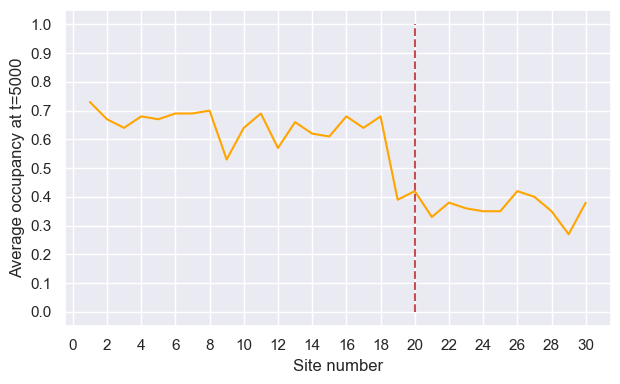

In [53]:
rinimo(t=1000,l_rb=2)